Code to read survey results

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

Data Reading and Preparation:

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.express as px

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

import sys
import json
# Add the parent directory to the path
sys.path.append('..')

# Now you can import the config module
from config import groqkey, OPENAI_Key

In [2]:
def read_ods(filename):
    # Use pandas to read the ODS file. The `engine='odf'` parameter is necessary to read ODS files.
    # Adjust the `sheet_name` parameter as needed. By default, it reads the first sheet.
    df = pd.read_excel(filename, engine='odf')
    return df

# Define a function to replace "not numbered" with the value in "Variable Label"
def replace_not_numbered(row):
    if row["Question number\n (Questionnaire file)"] == "not numbered":
        return row["Variable Label\n (Data files)"]
    else:
        return row["Question number\n (Questionnaire file)"]

In [3]:
# Replace 'example.ods' with the path to your ODS file
filename = 'dataverse_files\Wave1\SCALAR_Coastal_Longitudinal_Study_Wave_1_map.ods'

# Read the ODS file
metaInfo = read_ods(filename)

# Initialize empty lists to store grouped response options
question_numbers = []
variable_labels = []
descriptions = []
response_options = []

# Loop through DataFrame rows
current_question = None
for index, row in metaInfo.iterrows():
    if not pd.isnull(row['Question number(Questionnaire file)']):
        # If it's a new question, store its details
        current_question = row['Question number(Questionnaire file)']
        question_numbers.append(row['Question number(Questionnaire file)'])
        variable_labels.append(row['Variable Label(Data files)'])
        descriptions.append(row['Description'])
        response_options.append([(row['Values'], row['Value labels'])])
    elif current_question is not None:
        # If it's a response option, add it to the previous question's response options
        response_options[-1].append((row['Values'], row['Value labels']))

# Create a new DataFrame with grouped response options
grouped_df = pd.DataFrame({
    'Question number(Questionnaire file)': question_numbers,
    'Variable Label(Data files)': variable_labels,
    'Description': descriptions,
    'Response Options': response_options
})

grouped_df

,Question number(Questionnaire file),Variable Label(Data files),Description,Response Options
0,ID,ID,Respondent ID to match respondents between waves,"[(nan, nan)]"
1,not numbered,Q0_age,Age,"[(1.0, 16-24), (2.0, 25-34), (3.0, 35-44), (4...."
2,not numbered,Q0_gender,What gender do you identify with?,"[(1.0, Male), (2.0, Female)]"
3,not numbered,Q0_race_US,What race do you self-identify as? (USA only),"[(1.0, White), (2.0, Black or African American..."
4,not numbered,Q0_ethnicity_ID,What ethnic group do you identify as? (Indones...,"[(1.0, Jawa), (2.0, Sunda), (3.0, Madura), (4...."
...,...,...,...,...
214,Q60,Q60_elder,Yes – adults over 70,"[(0.0, No), (1.0, Yes)]"
215,Q60,Q60_no,No,"[(0.0, No), (1.0, Yes)]"
216,Q60,Q60_not_say,Prefer not to say,"[(0.0, No), (1.0, Yes)]"
217,Q60a,Q60a_parent,Are you the parent or guardian of any children...,"[(0.0, No), (1.0, Yes)]"


In [4]:
#Wave 1 - All data of NL
Survey_Responses = pd.read_csv("dataverse_files\SCALAR_Coastal_Longitudinal_Study_Wave_One_NL.csv").set_index("ID")

In [34]:
Survey_Overview  = pd.read_excel('Survey Questions Overview.xlsx', sheet_name='Wave 1', engine='openpyxl')
# Clean the survey questions dataframe to make it more usable for mapping
# Fill forward non-null ADICO Category values to apply them to all relevant rows, Specify the columns to forward fill excluding "Values" and "Value labels"
columns_to_ffill = [col for col in Survey_Overview.columns if col not in ["Values", "Value labels"]]

# Forward fill the specified columns
Survey_Overview[columns_to_ffill] = Survey_Overview[columns_to_ffill].ffill()
Survey_Overview = Survey_Overview.rename(columns={'ADICO Category': 'ADICO_Category'})

# Apply the function to replace "not numbered" with the value in "Variable Label"
Survey_Overview["Question number\n (Questionnaire file)"] = Survey_Overview.apply(replace_not_numbered, axis=1)
Survey_Overview['Value labels'] = Survey_Overview['Value labels'].astype(str)

# Set the index to {value of "Question number\n (Questionnaire file)"} + "_" + {str(value of "Values")}
Survey_Overview.set_index(Survey_Overview["Variable Label\n (Data files)"] + "_" + Survey_Overview["Values"].astype(str), inplace=True)
Survey_Overview.drop("ID_nan", inplace=True)
Survey_Overview.drop_duplicates(inplace=True)

question_answers_list = []
# Define a function to create the combined string
def combine_description_and_labels(group, question_answers_list, qnum):
    question_subset = Survey_Overview[Survey_Overview["Question number\n (Questionnaire file)"] == group["Question number\n (Questionnaire file)"].iloc[0]]
    # Check if it's the first row instance with the current "Question number\n (Questionnaire file)" column value
    first_instance_index = question_subset[question_subset.duplicated(subset=["Question number\n (Questionnaire file)"], keep="first")].index
    combined_string = ""
    # Concatenate the current row's "Description" and all "Value labels" values
    combined_string += str(group["Description"].iloc[0]) + ", " #+ "; ".join(group["Value labels"].astype(str))
    
    if first_instance_index.size != 0:
        first_description = question_subset["Description"].iloc[0]
        if first_description != group["Description"].iloc[0]:
         # If not the first instance, start with the first instance's "Description" column value
            combined_string += first_description

    question_answers_list = question_answers_list + [combined_string] * group.shape[0]  # Extend the list with the combined strings
    return question_answers_list

# Group by "Variable Label\n (Data files)" and apply the function to create the combined string
for group in Survey_Overview.groupby("Variable Label\n (Data files)",sort=False):
    question_answers_list = combine_description_and_labels(group[1], question_answers_list, group[1]["Question number\n (Questionnaire file)"].iloc[0])
Survey_Overview["full_question"] = question_answers_list


# Since the dataset has multiple rows per question for different value labels, we'll create a unique mapping
# Create the new mapping dictionary
question_adico_mapping = Survey_Overview[['full_question','ADICO_Category',"Variable Label\n (Data files)"]].drop_duplicates().set_index('full_question')

# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = list(set([Attribute for Attribute in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Conditions = list(set([Condition for Condition in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))
Aims = list(set([Aim for Aim in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Aim", "Aim/Condition"])]['Variable Label\n (Data files)']]))
Attcons = list(set([Attcon for Attcon in question_adico_mapping[question_adico_mapping['ADICO_Category'].isin(["Attribute", "Condition",'Aim/Condition', "Attribute/Condition"])]['Variable Label\n (Data files)']]))

c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning:

Data Validation extension is not supported and will be removed



Decision tree question selection:

In [6]:
#Selected attributes, aims, and conditions we would like to explore and test for case study validation
chosen_aims =  [
    "R2_implementation_SM1",
    "R2_implementation_SM2",
    "R2_implementation_SM3",
    "R2_implementation_NM2",
    "R2_implementation_NM3",
    "R2_implementation_NM4",
    "R2_implementation_NM6",
]
base_conditions = [
    "Q0_age",
    "R05_worry",
]
efficacy_conditions = [
    "R1a_self_efficacy_SM1",
    "R1a_self_efficacy_SM2",
    "R1a_self_efficacy_SM3",
    "R1a_self_efficacy_NM2",
    "R1a_self_efficacy_NM3",
    "R1a_self_efficacy_NM4",
    "R1a_self_efficacy_NM6",
]
cost_conditions = [
    "R1c_perc_cost_SM1",
    "R1c_perc_cost_SM2",
    "R1c_perc_cost_SM3",
    "R1c_perc_cost_NM2",
    "R1c_perc_cost_NM3",
    "R1c_perc_cost_NM4",
    "R1c_perc_cost_NM6",
]

chosen_attributes = []

#Creating list of all conditions
chosen_conditions = base_conditions + efficacy_conditions + cost_conditions

In [35]:
#Selected attributes, aims, and conditions we would like to explore and test for policy analysis validation
chosen_aims =  [
    "R2_implementation_SM3",
    "R2_implementation_SM6",
]
base_conditions = [
    "R08_economic_comfort",
    "R01_resilience_6",
]
efficacy_conditions = [
    "R1a_self_efficacy_SM3",
    "R1a_self_efficacy_SM6",
]
cost_conditions = [
    "R1c_perc_cost_SM3",
    "R1c_perc_cost_SM6",
]

chosen_attributes = []

#Creating list of all conditions
chosen_conditions = base_conditions + efficacy_conditions + cost_conditions

In [88]:
#You should skip this step if you have loaded an adjusted and completed overview file

adjusted_overview = Survey_Overview.copy()

#Prepare responses to be binary outcomes
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(chosen_aims)) & (adjusted_overview['Values'] == 2), 'Value labels'] = "I have or will soon implement this measure" #changes the text of the response for implementation value 6 to "Do not intend to"  
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(chosen_aims)) & (adjusted_overview['Values'] == 6), 'Value labels'] = "I have not implemented this measure and won't within the next year" #changes the text of the response for age option 3 to "50 or younger"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R05_worry") & (adjusted_overview['Values'] == 5), 'Value labels'] = "Worried" #changes the text of the response to "Worried"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R05_worry") & (adjusted_overview['Values'] == 1), 'Value labels'] = "Not Worried" #changes the text of the response to "Not Worried"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "Q0_age") & (adjusted_overview['Values'] == 5), 'Value labels'] = "Older than 45" #changes the text of the response to "Older than 45"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "Q0_age") & (adjusted_overview['Values'] == 1), 'Value labels'] = "Younger than 45" #changes the text of the response to "Younger than 45"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R08_economic_comfort") & (adjusted_overview['Values'] == 5), 'Value labels'] = "Living comfortably" #changes the text of the response to "Living comfortably"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R08_economic_comfort") & (adjusted_overview['Values'] == 1), 'Value labels'] = "Not living comfortably" #changes the text of the response to "Not living comfortably"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R01_resilience_6") & (adjusted_overview['Values'] == 5), 'Value labels'] = "I don't agree" #changes the text of the response to "I don't agree"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == "R01_resilience_6") & (adjusted_overview['Values'] == 1), 'Value labels'] = "I agree" #changes the text of the response to "I agree"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(efficacy_conditions)) & (adjusted_overview['Values'] == 5), 'Value labels'] = "I am able to" #changes the text of the response to "I am able to"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(efficacy_conditions)) & (adjusted_overview['Values'] == 1), 'Value labels'] = "I am not able to" #changes the text of the response to "I am not able to"

adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(cost_conditions)) & (adjusted_overview['Values'] == 5), 'Value labels'] = "Expensive" #changes the text of the response to "Expensive"
adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'].isin(cost_conditions)) & (adjusted_overview['Values'] == 1), 'Value labels'] = "Cheap" #changes the text of the response to "Cheap"


#If it doesn't exist yet, create a column in overview which should eventually contain the question and response rewritten in ADICO syntax
try: adjusted_overview["IG_Component"]
except: adjusted_overview["IG_Component"] = adjusted_overview["full_question"] +" Response: " + adjusted_overview['Value labels']


#exclude any "dont know" or "prefer not to say responses" from the question overview data
adjusted_overview = adjusted_overview[adjusted_overview['Values'] < 90]


In [89]:
adjusted_responses = Survey_Responses.copy().dropna(axis=1)

for column in chosen_aims:
    #for case study
    # #Simplify the implementation responses to yes i intend to or no I not intend to make this change
    # adjusted_responses.loc[adjusted_responses[column] > 5, column] = 6 #if they dont intend to
    # adjusted_responses = adjusted_responses[adjusted_responses[column] != 1] #Exclude people that already have
    # adjusted_responses.loc[adjusted_responses[column] <= 5, column] = 2 #if they intend to

    # for policy test
    #Simplify the implementation responses to yes i have or no I have not
    adjusted_responses.loc[adjusted_responses[column] > 3, column] = 6 #if they have not
    adjusted_responses.loc[adjusted_responses[column] <= 3, column] = 2 #if they have/will soon
    
for column in base_conditions + efficacy_conditions + cost_conditions:
    #Preprocess key condition question responses to binary outcomes and remove any don't know responses
    adjusted_responses = adjusted_responses[adjusted_responses[column] <= 10]
    adjusted_responses.loc[adjusted_responses[column] > 3, column] = 5
    adjusted_responses.loc[adjusted_responses[column] <= 3, column] = 1


# Make lists of question data for each of the selected ADICO groups
chosen_aims_overview = adjusted_overview[(adjusted_overview['Variable Label\n (Data files)'].isin(chosen_aims)) & (adjusted_overview['Values'].isin([2,6]))][['full_question', 'Value labels']]
chosen_conditions_overview = adjusted_overview[(adjusted_overview['Variable Label\n (Data files)'].isin(chosen_conditions)) & (adjusted_overview['Values'].isin([1,5]))][['full_question', 'Value labels']]
chosen_attributes_overview = adjusted_overview[adjusted_overview['Variable Label\n (Data files)'].isin(chosen_attributes)][['full_question', 'Value labels']]

In [90]:
# Check if any of the selected aims or conditions don't exist in the repsonses data 
for column in chosen_conditions+chosen_aims:
    try:
        adjusted_responses[column]
    except: 
        print(column, "not in Survey responses")

Generating Parallel Set Diagrams

In [91]:
# Loop through each item in the list of chosen aims
for item in range(len(chosen_aims)):
    aim = chosen_aims[item]
    
    # Combine base conditions with efficacy and cost conditions for the current aim
    conditions = base_conditions #+ [efficacy_conditions[item]] + [cost_conditions[item]]
    paralelsetdf = adjusted_responses[[aim] + conditions].astype(str)

    # Define custom color mapping
    color_mapping = {
        "2": "#00a6d6",
        "6": "#a7a7a7"
    }

    # Apply color mapping
    paralelsetdf['color'] = paralelsetdf[aim].map(color_mapping)
    

    # Update labels to provide the need
    aimcounts = paralelsetdf[aim].value_counts()
    paralelsetdf.loc[paralelsetdf[aim] == str(2), aim] = f"Have or<br>will soon<br>({aimcounts.loc[str(2)]})"
    paralelsetdf.loc[paralelsetdf[aim] == str(6), aim] = f"Have not<br>({aimcounts.loc[str(6)]})"

    for condition in base_conditions:
      concounts = paralelsetdf[condition].value_counts()
      for val in paralelsetdf[condition].unique():
            # Update labels to provide the need
            label = adjusted_overview.loc[(adjusted_overview['Variable Label\n (Data files)'] == condition) & (adjusted_overview['Values'] == float(val)), "Value labels"].iloc[0]
            paralelsetdf.loc[paralelsetdf[condition] == val, condition] = f"{label}<br>({concounts.loc[val]})"
        

    # Create the parallel categories plot
    fig = px.parallel_categories(
        paralelsetdf,
        dimensions=[aim] + conditions,
        color='color',
    )
    # Update the layout of the figure with a title and font size
    fig.update_layout(title_text="People living in the Netherlands: " + adjusted_overview[adjusted_overview['Variable Label\n (Data files)'] == aim]["Description"].iloc[0], 
                      height=500,
                      width=1000,
                        title_font=dict(size=15, ),  # Set title font size here
                        font=dict(size=18)  # Set default font size here (for labels, etc.)
    )
    
    # Show the plot
    fig.show()


In [92]:
# Loop through each item in the list of chosen aims
for item in range(len(chosen_aims)):
    aim = chosen_aims[item]
    
    # Combine base conditions with efficacy and cost conditions for the current aim
    conditions = [efficacy_conditions[item]] + [cost_conditions[item]]
    paralelsetdf = adjusted_responses[[aim] + conditions].astype(str)

    # Define custom color mapping
    color_mapping = {
        "2": "#00a6d6",
        "6": "#a7a7a7"
    }

    # Apply color mapping
    paralelsetdf['color'] = paralelsetdf[aim].map(color_mapping)

    # Update labels to provide the need
    aimcounts = paralelsetdf[aim].value_counts()
    paralelsetdf.loc[paralelsetdf[aim] == str(2), aim] = f"Have or<br>will soon<br>({aimcounts.loc[str(2)]})"
    paralelsetdf.loc[paralelsetdf[aim] == str(6), aim] = f"Have not<br>({aimcounts.loc[str(6)]})"

  
    efficacy_concounts = paralelsetdf[efficacy_conditions[item]].value_counts()
    paralelsetdf.loc[paralelsetdf[efficacy_conditions[item]] == str(1), efficacy_conditions[item]] = f"Not able<br>({efficacy_concounts.loc[str(1)]})"
    paralelsetdf.loc[paralelsetdf[efficacy_conditions[item]] == str(5), efficacy_conditions[item]] = f"Able<br>({efficacy_concounts.loc[str(5)]})"
    
    cost_concounts = paralelsetdf[cost_conditions[item]].value_counts()
    paralelsetdf.loc[paralelsetdf[cost_conditions[item]] == str(1), cost_conditions[item]] = f"Cheap<br>({cost_concounts.loc[str(1)]})"
    paralelsetdf.loc[paralelsetdf[cost_conditions[item]] == str(5), cost_conditions[item]] = f"Expensive<br>({cost_concounts.loc[str(5)]})"

    # Create the parallel categories plot
    fig = px.parallel_categories(
        paralelsetdf,
        dimensions=[aim] + conditions,
        color='color',
    )
    # Update the layout of the figure with a title and font size
    fig.update_layout(title_text="People living in the Netherlands: " + adjusted_overview[adjusted_overview['Variable Label\n (Data files)'] == aim]["Description"].iloc[0], 
                      height=500,
                      width=1050,
                        title_font=dict(size=15),  # Set title font size here
                        font=dict(size=18)  # Set default font size here (for labels, etc.)
    )
    
    # Show the plot
    fig.show()


Generating IG Syntax Components

In [93]:
##Json Approach
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[1], api_key=groqkey)
# models = ["gpt-3.5-turbo-0125", "gpt-4o"]
# llm = ChatOpenAI(temperature=0, model=models[1], api_key=OPENAI_Key)


"""Here is an example: "Attribute": "People", "Aim":"do this specific action", "Condition1": "if this condition is met", "Condition2": "and this condition is met" """

def ExampleCompletionFunction(questions, ADICO_component):
    # statlist = []
    IG_components = pd.DataFrame(columns=["IG_Component"])
    for question in questions['full_question'].unique():
        questionset = questions[questions['full_question'] == question] 

        request = questionset.to_json(orient='index', index=True)
        
        system = f"""You are a json interpreter that transforms survey questions and responses into structured informal rule institutional statement components in 3rd person.
                    The input json will have the following structure:
                    Object Key = identifier of question and answer pair
                    With nested values
                    full_question: Text of the question being asked
                    Value labels = a response option for the question    

                    You output json must have the following structure:
                    Object Key = the same identifier of question and answer pair
                    IG_Component = The rewritten question and answer as Institutional Grammar 

                    I should be able to combine any output Attribute + Aim + Condition to form a full 3rd-person sentence that describes behaviour. 
                    Be concise but do not simplify or generalise the actions and conditions.  
                    If a response option is just a number, relate it to the other options for that question 
                    Always produce a single JSON containing the same (number of) question identifies  as have been provided.

                    In this instance the questions you have been provided are '{ADICO_component}'. Perform the text conversion below.
                    """     
        system +=   {'Attributes':'demographic of the survey responses, should be written as "People (rewritten question and answer)" e.g. "People who are male"',
                    'Aims': "action question the and the response, should be written as an action e.g. 'sell their house', no subject of the sentence",
                    'Conditions': "condition question and response, should be rewritten as 'if (rewritten question and answer)' in 3rd person ('they') e.g. 'if they feel they cannot rely on government support'"}[ADICO_component]


        human = "{text}"
        prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

        chain = prompt | llm
        response = chain.invoke({"text": request})

        # Extract the JSON string from the text
        start = response.content.find("{")
        end = response.content.rfind("}") + 1
        json_str = response.content[start:end]

        # Parse the JSON string into a Python dictionary
        try:
            data_dict = json.loads(json_str)        
        except: 
            # Replace all instances of "}}" with "}", and remove any incorrect json formatting
            json_str = json_str.replace("}}", "}")+"}"
            json_str = json_str.replace(",\n{", ",\n")
            json_str = json_str.replace(",{", ",")

            # Load the JSON string into a dictionary
            data_dict = json.loads(json_str)

        IG_components = pd.concat([IG_components, pd.DataFrame.from_dict(data_dict, orient='index')])
    return IG_components

chosen_aims_overview['IG_Component'] = ExampleCompletionFunction(chosen_aims_overview, "Aims")
chosen_attributes_overview['IG_Component'] = ExampleCompletionFunction(chosen_attributes_overview, "Attributes")
chosen_conditions_overview['IG_Component'] = ExampleCompletionFunction(chosen_conditions_overview, "Conditions")

In [94]:
adjusted_overview['IG_Component'] =  pd.concat([chosen_aims_overview, chosen_attributes_overview, chosen_conditions_overview])['IG_Component']
adjusted_overview.dropna(inplace=True)
adjusted_overview.sort_index(inplace=True)

In [95]:
# Function that takes a tree and an index value of a tree node that satisfies the conditions to be a statement and generates a row for the statement table
def makeTreeStatement(tree, satisfactory_index, classes, features, attributeGroup, aim, Aim_description):
    # Get the aim outcome of the node (which action has more samples)
    class_index = np.argmax(tree.value[satisfactory_index]) 
    Aim_resp = classes[class_index]

    # Retrieve the class counts at the root node
    aim_resp_count = tree.value[0][0]  # Gets the counts for each class
    
    # get how many in people answered with this aim outcome
    total_aim_percent = aim_resp_count[class_index]/tree.n_node_samples[0]

    if satisfactory_index == 0:
        condition2 = condition1 = None, 
        Condition2_description = Condition1_description = None
        condition2_rows_of_leaf = condition1_rows_of_leaf = ["None"] 
        condition2_count = condition1_count = tree.n_node_samples[0]
        condition2_aim_resp_percent = condition1_aim_resp_percent = total_aim_percent
    else:
        condition1 = features[tree.feature[0]]   # Get the condition used for the root node
        #get the description of the first condition question used
        Condition1_description = adjusted_overview[adjusted_overview["Variable Label\n (Data files)"] == condition1.strip()]['full_question'].iat[0]
        #Rows of question data for condition1
        condition1_rows = adjusted_overview[adjusted_overview['Variable Label\n (Data files)'] == condition1]

        satisfactory_leaf_is_left = tree.feature[satisfactory_index - 1] != -2  # Determine if the leaf is on the "left"
        
        if satisfactory_leaf_is_left: # The leaf meets the threshold      
            leaf_parent_index = satisfactory_index - 1
        else:  # The leaf does not meet the threshold (falls outside the threshold)
            leaf_parent_index = satisfactory_index - 2
            if tree.feature[leaf_parent_index] == -2: #was directly connected to root and on the right 
                leaf_parent_index = 0

        if leaf_parent_index != 0: #if the leaf is not directly connected to the root node
            root_threshold = tree.threshold[0]  # get the threshold used on the root node
            parent_is_left = leaf_parent_index - 1 == 0  # Determine if the parent is on the "left"

            # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
            if parent_is_left: # The parent meets the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] <= root_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]

            else: # The leaf does not meet the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] > root_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                    

            condition1_count = tree.n_node_samples[leaf_parent_index]
            condition1_aim_resp_percent = tree.value[leaf_parent_index][0, class_index]/condition1_count

            condition2 = features[tree.feature[leaf_parent_index]]

            Condition2_description = adjusted_overview[adjusted_overview["Variable Label\n (Data files)"] == condition2.strip()]['Description'].iat[0]

            threshold2 = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition2_rows = adjusted_overview[adjusted_overview['Variable Label\n (Data files)'] == condition2]         
            if satisfactory_leaf_is_left:
                condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] <= threshold2]['IG_Component']
                if "R1" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[0]]
                elif "R0" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[0]]
            else: 
                condition2_rows_of_leaf = condition2_rows[condition2_rows['Values'] > threshold2]['IG_Component']
                if "R1" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition2:
                    condition2_rows_of_leaf = [condition2_rows_of_leaf.tolist()[-1]]

            condition2_count = tree.n_node_samples[satisfactory_index]
            condition2_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition2_count
    
        else:
            condition1 = features[tree.feature[leaf_parent_index]]
            parent_threshold = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition1_rows = adjusted_overview[adjusted_overview['Variable Label\n (Data files)'] == condition1]

            if satisfactory_leaf_is_left:
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] <= parent_threshold]['IG_Component']
                if "R1" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[0]]

            else: 
                condition1_rows_of_leaf = condition1_rows[condition1_rows['Values'] > parent_threshold]['IG_Component']
                if "R1" in condition1:
                    print(condition1_rows_of_leaf)
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]
                elif "R0" in condition1:
                    condition1_rows_of_leaf = [condition1_rows_of_leaf.tolist()[-1]]

            condition1_count = tree.n_node_samples[satisfactory_index]
            condition1_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition1_count
            
            condition2 = None
            Condition2_description = None
            condition2_rows_of_leaf = ["None"] 
            condition2_count = condition1_count
            condition2_aim_resp_percent = condition1_aim_resp_percent

    # Create a new row with specified values
    new_row = {
        'Attribute': attributeGroup,

        'Aim': aim,
        'Aim_description': Aim_description,
        'Aim_resp': Aim_resp,  # Class with the lowest entropy
        'Total_count':tree.n_node_samples[0], 
        'Aim_%_True': total_aim_percent,

        'Condition1': condition1,
        'Condition1_description': Condition1_description,
        'Condition1_resp': ", ".join(condition1_rows_of_leaf),
        'Condition1_count': condition1_count,
        'Condition1_Aim_%': condition1_aim_resp_percent, 

        'Condition2': condition2, 
        'Condition2_description': Condition2_description,
        'Condition2_resp': ", ".join(condition2_rows_of_leaf), 
        'Condition2_count': condition2_count,
        'Condition2_Aim_%': condition2_aim_resp_percent,

        'final_entropy': tree.impurity[satisfactory_index]
    }
    return new_row

In [96]:
def select_statements(chosen_aims, chosen_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion):
    print(attributeGroup)
    for aim in chosen_aims:
        # Find the relevant row and value labels
        aimRow = adjusted_overview[adjusted_overview["Variable Label\n (Data files)"] == aim]
        aimRow0 = str(aimRow.at[aimRow.index[0], "IG_Component"])
        aimRow1 = str(aimRow.at[aimRow.index[-1], "IG_Component"])
        classes = [aimRow0,aimRow1]

        Aim_description = adjusted_overview[adjusted_overview["Variable Label\n (Data files)"] == aim.strip()]['full_question'].iat[0]

        print(f"Processing aim: {aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
        
        #filter out the "I have already implemented options"
        responses = responses[responses[aim] <=6]

        # Split the data
        X = responses[chosen_conditions].values
        Y = responses.loc[:, aim].values


        sample_demographic_size = len(Y)

        clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=2)
        clf_entropy.fit(X, Y)

        #list of the condtions we test
        features = chosen_conditions
    
        # 'clf_entropy' is your trained decision tree classifier
        tree = clf_entropy.tree_

        #Identify leaf indices (where feature is -2)
        leaf_indices = np.where(tree.feature == -2)[0]

        #Find nodes where entropy is within the threshold
        pure_enough_nodes = np.where(tree.impurity <= entropy_threshold)[0]
        #Find nodes which have enough samples is within the threshold
        enough_sample_nodes = np.where(tree.n_node_samples >= int(sample_threshold*sample_demographic_size))[0]
        # Find the intersection of both lists
        satisfactory_nodes = np.intersect1d(pure_enough_nodes, enough_sample_nodes)
        
        for node in satisfactory_nodes:
            new_row = makeTreeStatement(tree, node, classes, features, attributeGroup, aim, Aim_description)
            # Using a new index to add a row directly
            ind = len(statement_questions)  # Determine the next index
            statement_questions.loc[ind] = new_row

            # Drop duplicates if needed
            statement_questions = statement_questions.drop_duplicates()
    

        #find the leaf with the lowest entropy
        least_entropy_index = leaf_indices[np.argmin(tree.impurity[leaf_indices])]
        final_entropy = tree.impurity[least_entropy_index]

        if final_entropy < entropy_threshold: 
            # Visualize the decision tree
            plt.figure(figsize=(25, 5))

            plot_tree(clf_entropy, filled=True, feature_names=features, class_names=classes)
            if "implementation" in aim: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'Description'])}")
            else: plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'full_question'])}")
            plt.show()
        
        if recursion < min(3, len(chosen_conditions)-2):
            recursion_conditions = [condition for condition in chosen_conditions if condition not in statement_questions["Condition1"].tolist()[-recursion:]]
            try:
                statement_questions = select_statements([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 
            except:
                print([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1)
                statement_questions = select_statements([aim], recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 


    return statement_questions

In [97]:
#create a table that will be filled by selected combinations of aims and conditions with the relevant information for further processing 
statement_questions = pd.DataFrame(columns = ['Attribute', 
                                              'Aim', 'Aim_description', 'Aim_resp', 'Total_count', 'Aim_%_True', 
                                              'Condition1', 'Condition1_description', 'Condition1_resp', 'Condition1_count', 'Condition1_Aim_%', 
                                              'Condition2', 'Condition2_description', 'Condition2_resp', 'Condition2_count', 'Condition2_Aim_%',
                                              'final_entropy'])

People living in the Netherlands
Processing aim: R2_implementation_SM3: Reconstructing or reinforcing the walls and/or the ground floor with water-resistant materials
R1c_perc_cost_SM3_5.0    if they believe that implementing or paying so...
Name: IG_Component, dtype: object


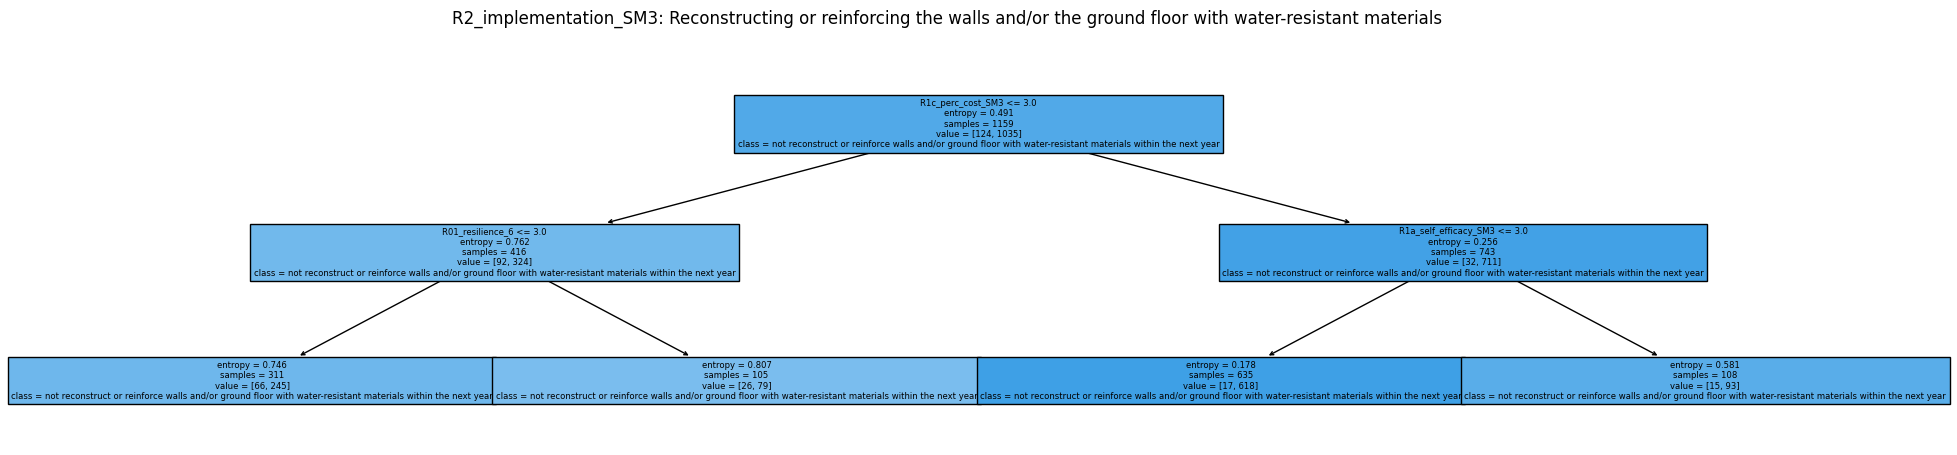

People living in the Netherlands
Processing aim: R2_implementation_SM3: Reconstructing or reinforcing the walls and/or the ground floor with water-resistant materials


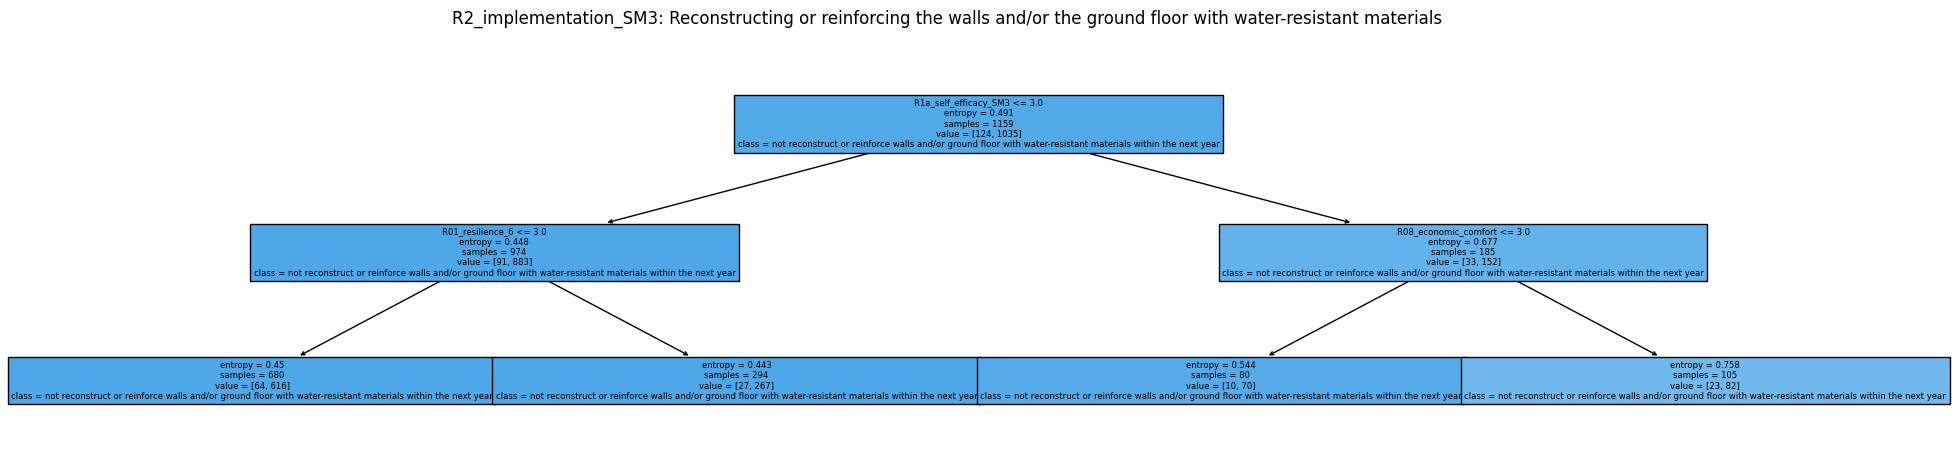

People living in the Netherlands
Processing aim: R2_implementation_SM6: Installing a pump and/or one or more system(s) to drain flood water
R1c_perc_cost_SM6_5.0    if they believe that implementing or paying so...
Name: IG_Component, dtype: object


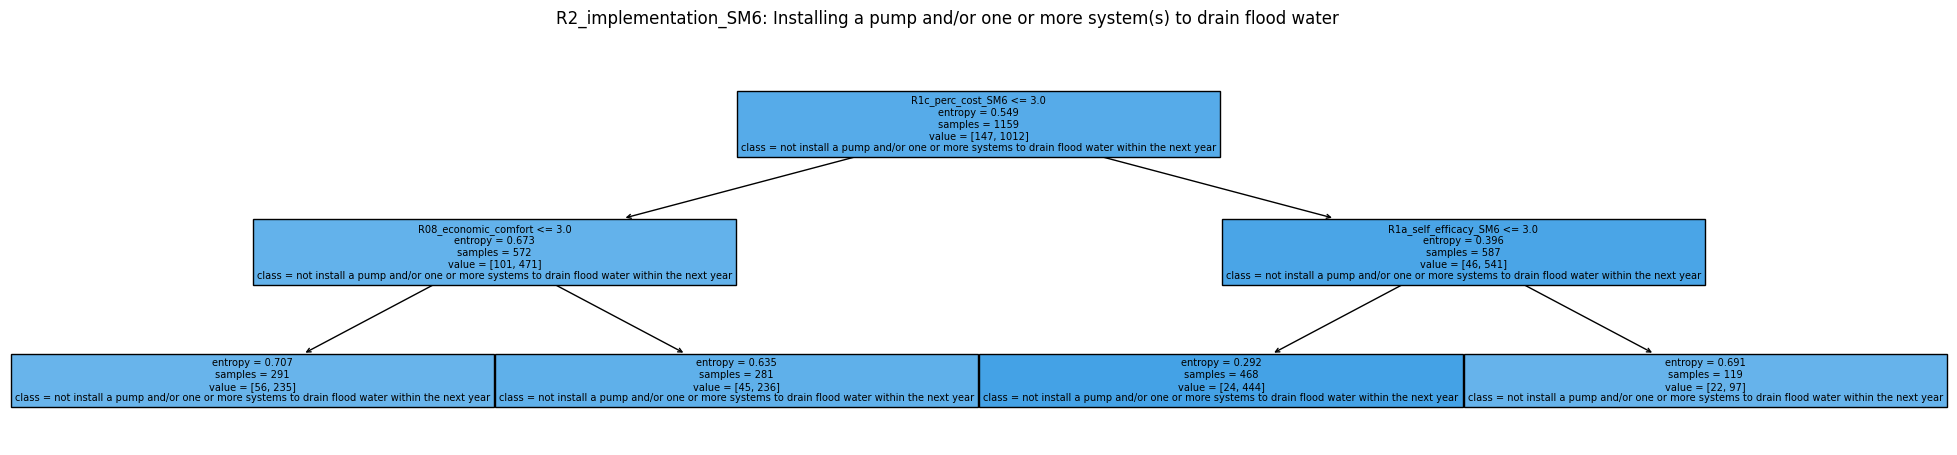

People living in the Netherlands
Processing aim: R2_implementation_SM6: Installing a pump and/or one or more system(s) to drain flood water


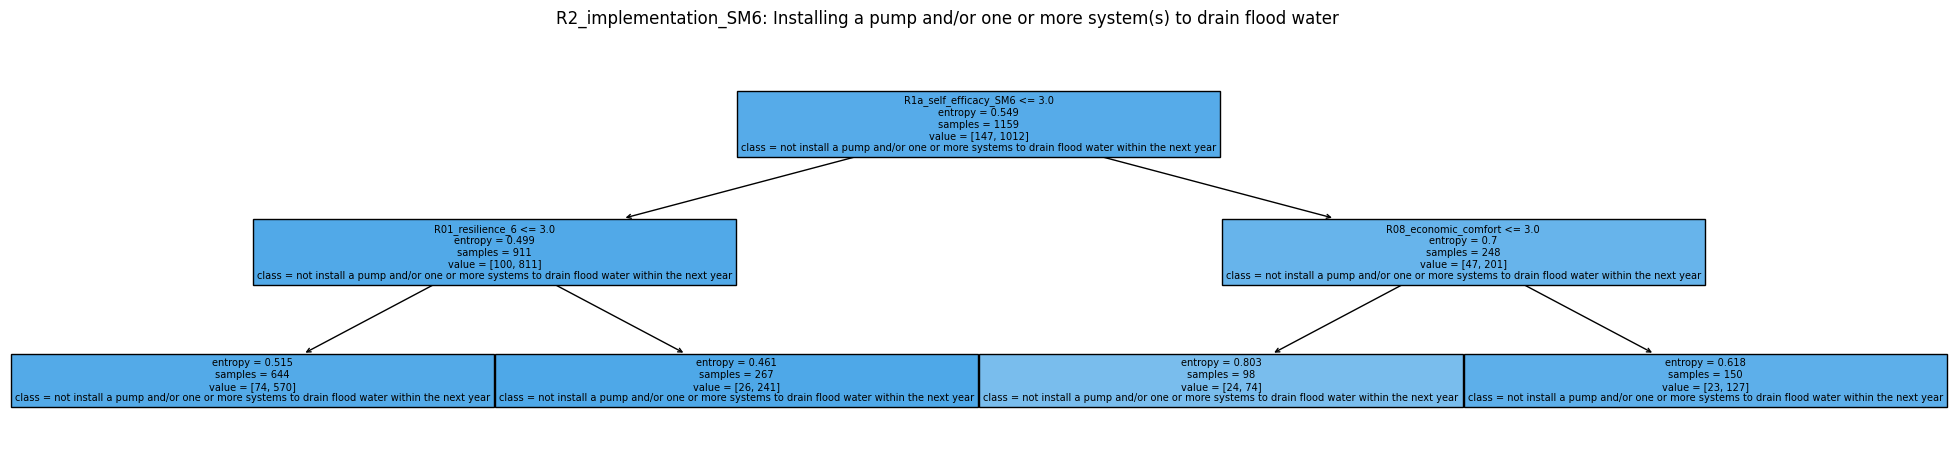

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,"(None,)",None,None,1159,0.893011,"(None,)",None,None,1159,0.893011,0.490766
1,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,416,0.778846,R01_resilience_6,My household can rely on the support from my g...,if they feel they can rely on government support,311,0.787781,0.745702
2,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,743,0.956931,None,None,None,743,0.956931,0.256189
3,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,743,0.956931,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,635,0.973228,0.177934
4,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,None,None,None,974,0.906571,0.447813
5,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,R01_resilience_6,My household can rely on the support from my g...,if they feel they can rely on government support,680,0.905882,0.450067
6,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,R01_resilience_6,My household can rely on the support from my g...,if they feel they cannot rely on government su...,294,0.908163,0.442571
7,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,"(None,)",None,None,1159,0.873167,"(None,)",None,None,1159,0.873167,0.548690
8,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,R1c_perc_cost_SM6,Installing a pump and/or one or more system(s)...,if they believe that implementing or paying so...,572,0.823427,None,None,None,572,0.823427,0.672523
9,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,R1c_perc_cost_SM6,Installing a pump and/or one or more system(s)...,if they believe that implementing or paying so...,572,0.823427,R08_economic_comfort,When considering your salary along with your e...,if they feel they are not living comfortably,291,0.807560,0.706548


In [98]:
#You can change these values:
entropy_threshold = 0.75 #How much entropy can the node have (yes aim:no aim) to be considered?
sample_threshold = 0.25 #What proportion of the original sample size to be considered?

for item in range(len(chosen_aims)):
    aim = [chosen_aims[item]]
    conditions = base_conditions + [efficacy_conditions[item]] + [cost_conditions[item]]
    statement_questions =  select_statements(aim, conditions, adjusted_responses, statement_questions, "People living in the Netherlands", entropy_threshold, sample_threshold, 0)

display(statement_questions)

# Save the DataFrame to a CSV file
statement_questions.to_csv("SCALAR_tree_selected_statements_PA.csv", index=False)

In [99]:
# Make final file
statements_stats = pd.concat([
                                 statement_questions['Attribute'], 
                                 statement_questions['Aim'], 
                                 statement_questions[['Total_count', 'Aim_%_True']],
                                 statement_questions['Condition1'], 
                                 statement_questions[['Condition1_count', 'Condition1_Aim_%',]],
                                 statement_questions['Condition2'],
                                 statement_questions[['Condition2_count', 'Condition2_Aim_%']], 
                                 ], axis=1)


# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('SCALARSelectedandConvertedStatements_PA.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
statements_stats.to_excel(writer, sheet_name='IGStatementStats', index=False)
statement_questions.to_excel(writer, sheet_name='QuestionResults', index=False)

# Close the Pandas Excel writer and output the Excel file
writer.close()

Statament BARPLOTS

In [100]:
import textwrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [101]:
statement_questions

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,"(None,)",None,None,1159,0.893011,"(None,)",None,None,1159,0.893011,0.490766
1,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,416,0.778846,R01_resilience_6,My household can rely on the support from my g...,if they feel they can rely on government support,311,0.787781,0.745702
2,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,743,0.956931,None,None,None,743,0.956931,0.256189
3,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1c_perc_cost_SM3,Reconstructing or reinforcing the walls and/or...,if they believe that implementing or paying so...,743,0.956931,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,635,0.973228,0.177934
4,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,None,None,None,974,0.906571,0.447813
5,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,R01_resilience_6,My household can rely on the support from my g...,if they feel they can rely on government support,680,0.905882,0.450067
6,People living in the Netherlands,R2_implementation_SM3,Reconstructing or reinforcing the walls and/or...,not reconstruct or reinforce walls and/or grou...,1159,0.893011,R1a_self_efficacy_SM3,Reconstructing or reinforcing the walls and/or...,if they are not able to undertake the structur...,974,0.906571,R01_resilience_6,My household can rely on the support from my g...,if they feel they cannot rely on government su...,294,0.908163,0.442571
7,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,"(None,)",None,None,1159,0.873167,"(None,)",None,None,1159,0.873167,0.548690
8,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,R1c_perc_cost_SM6,Installing a pump and/or one or more system(s)...,if they believe that implementing or paying so...,572,0.823427,None,None,None,572,0.823427,0.672523
9,People living in the Netherlands,R2_implementation_SM6,Installing a pump and/or one or more system(s)...,not install a pump and/or one or more systems ...,1159,0.873167,R1c_perc_cost_SM6,Installing a pump and/or one or more system(s)...,if they believe that implementing or paying so...,572,0.823427,R08_economic_comfort,When considering your salary along with your e...,if they feel they are not living comfortably,291,0.807560,0.706548


In [102]:
statement_questions.sort_values("final_entropy",inplace=True)
statement_questions.reset_index(inplace=True, drop=True)

In [105]:
for k in [0,1,2,3,4]:
    print(statement_questions.loc[k,"Aim_resp"])
    print(statement_questions.loc[k,"Condition1_resp"])
    print(statement_questions.loc[k,"Condition2_resp"])
    print(statement_questions.loc[k,"final_entropy"])

not reconstruct or reinforce walls and/or ground floor with water-resistant materials within the next year
if they believe that implementing or paying someone to implement this structural measure would be expensive
if they are not able to undertake the structural measure either themselves or by paying a professional to do so
0.1779340107206948
not reconstruct or reinforce walls and/or ground floor with water-resistant materials within the next year
if they believe that implementing or paying someone to implement this structural measure would be expensive
None
0.256189076205616
not install a pump and/or one or more systems to drain flood water within the next year
if they believe that implementing or paying someone to implement this structural measure would be expensive
if they do not have the ability to undertake the structural measure either themselves or by paying a professional to do so
0.29181825659888583
not install a pump and/or one or more systems to drain flood water within the

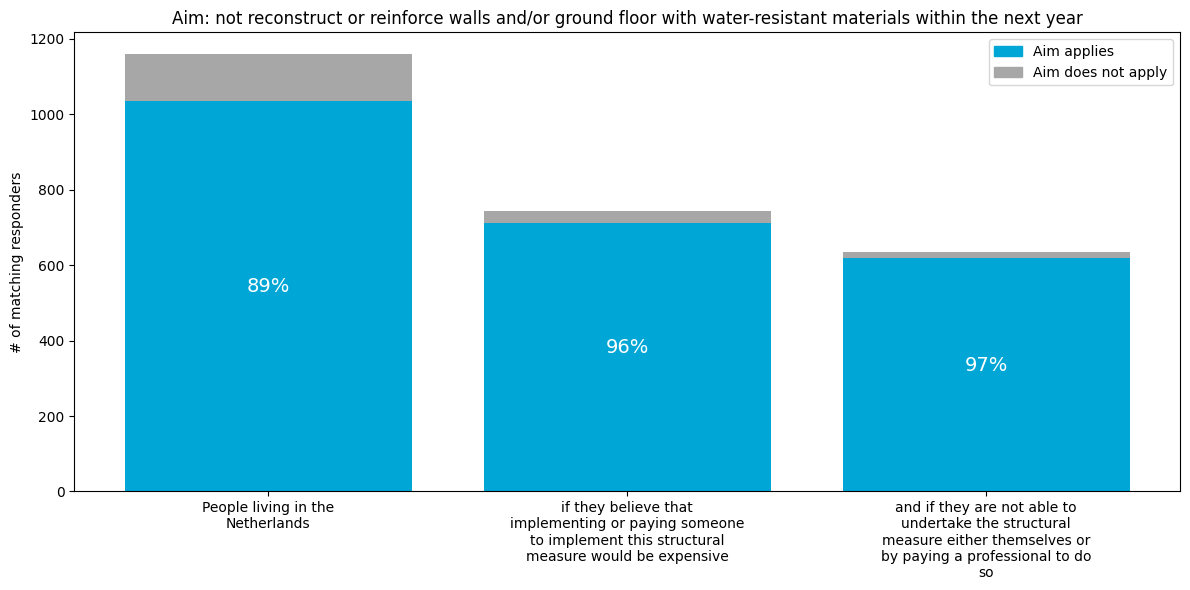

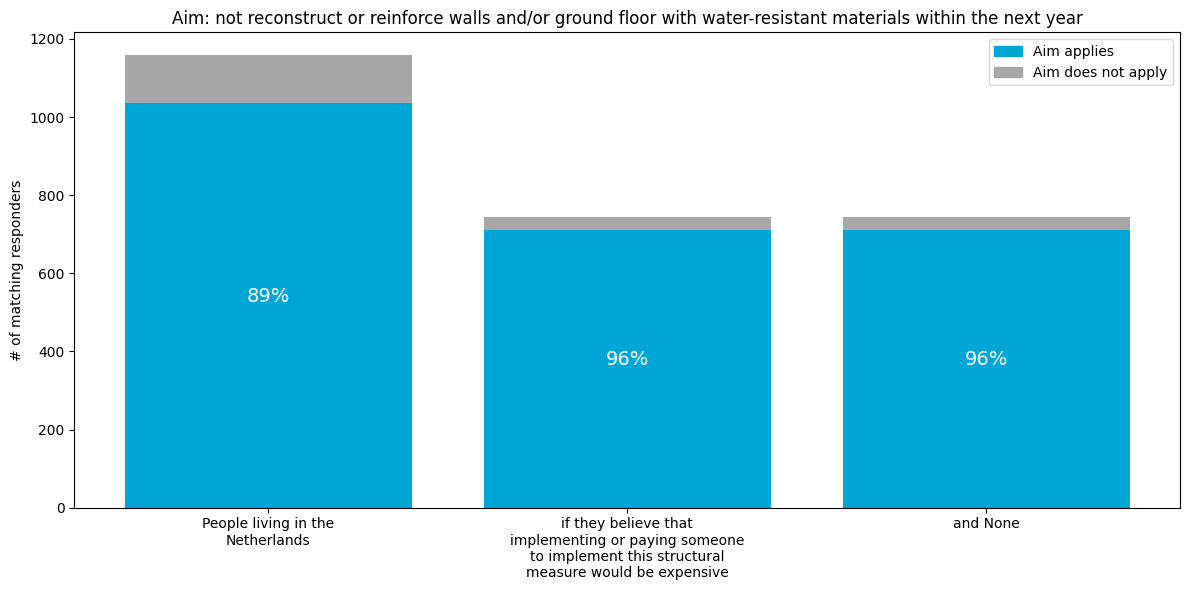

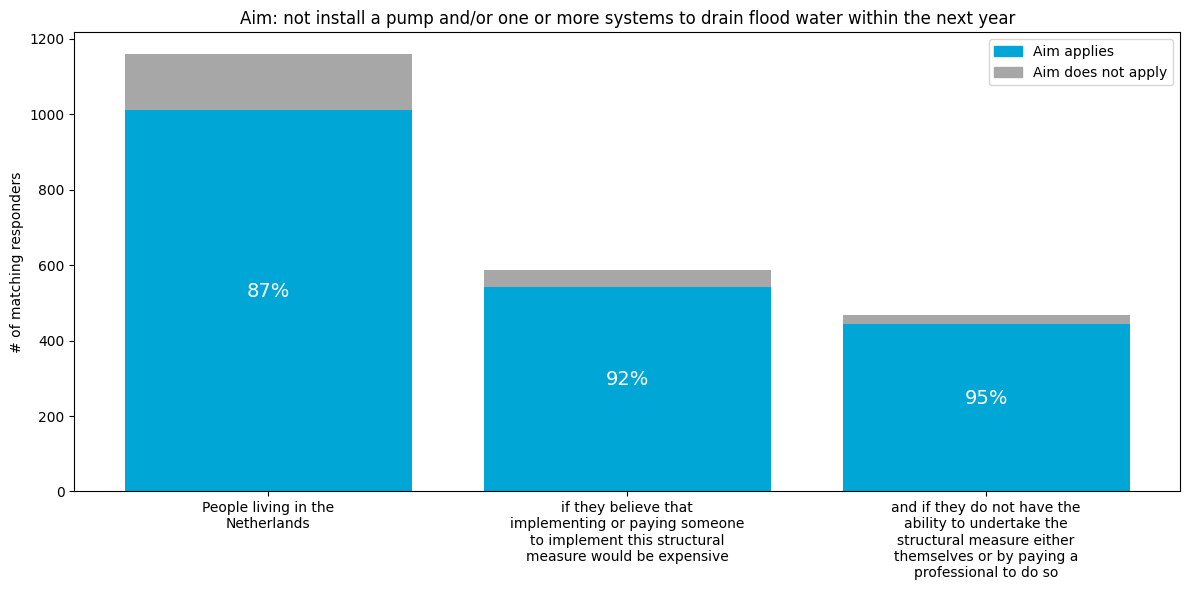

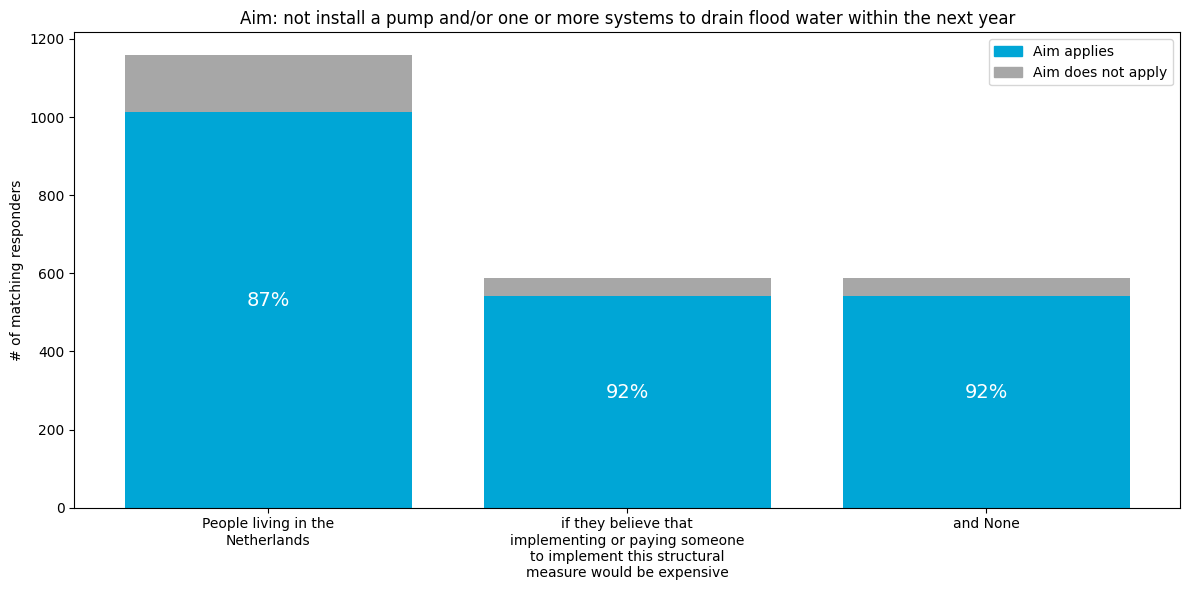

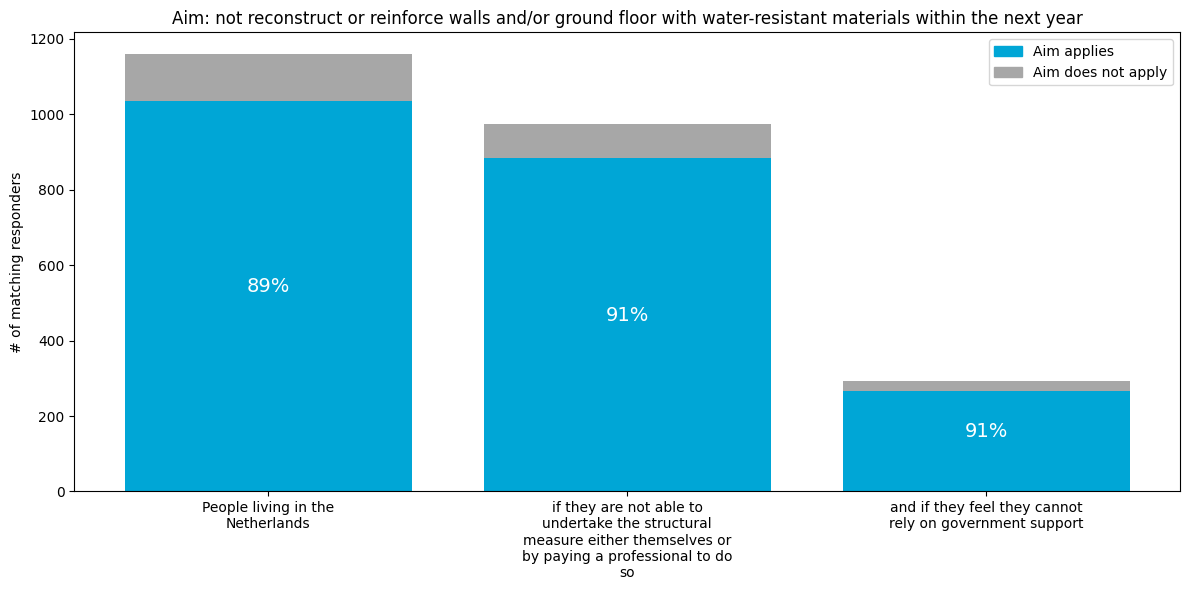

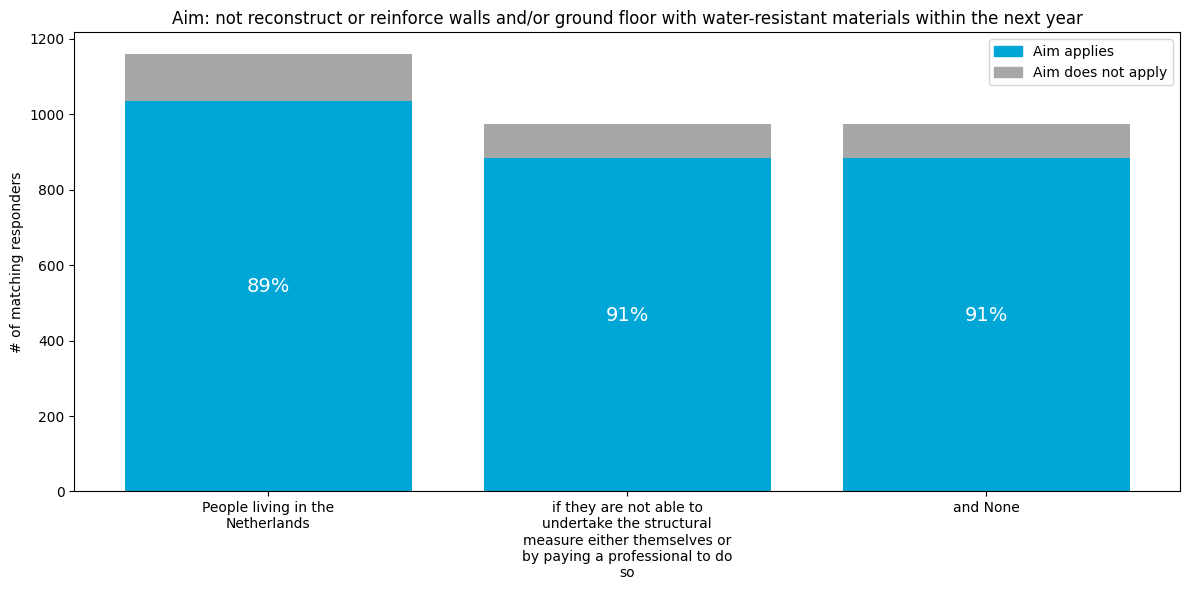

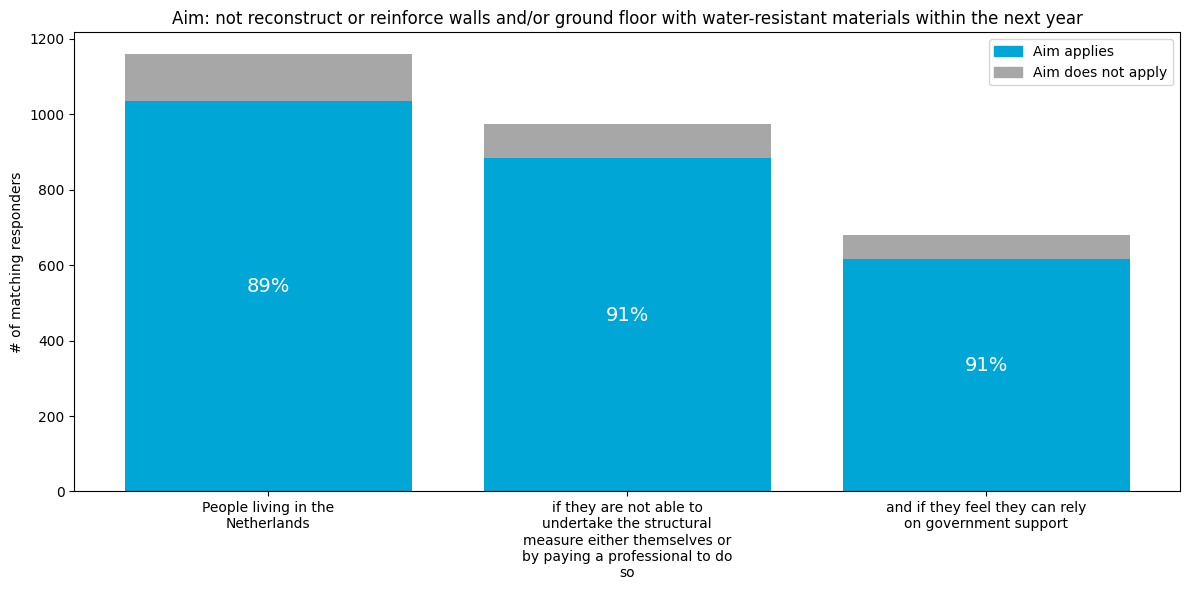

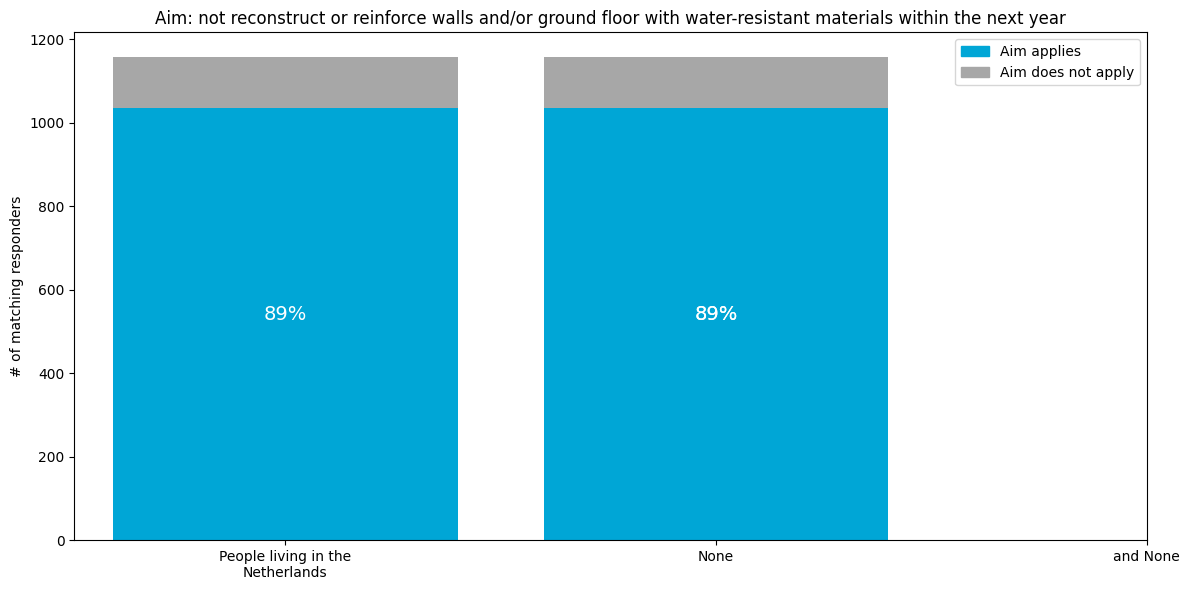

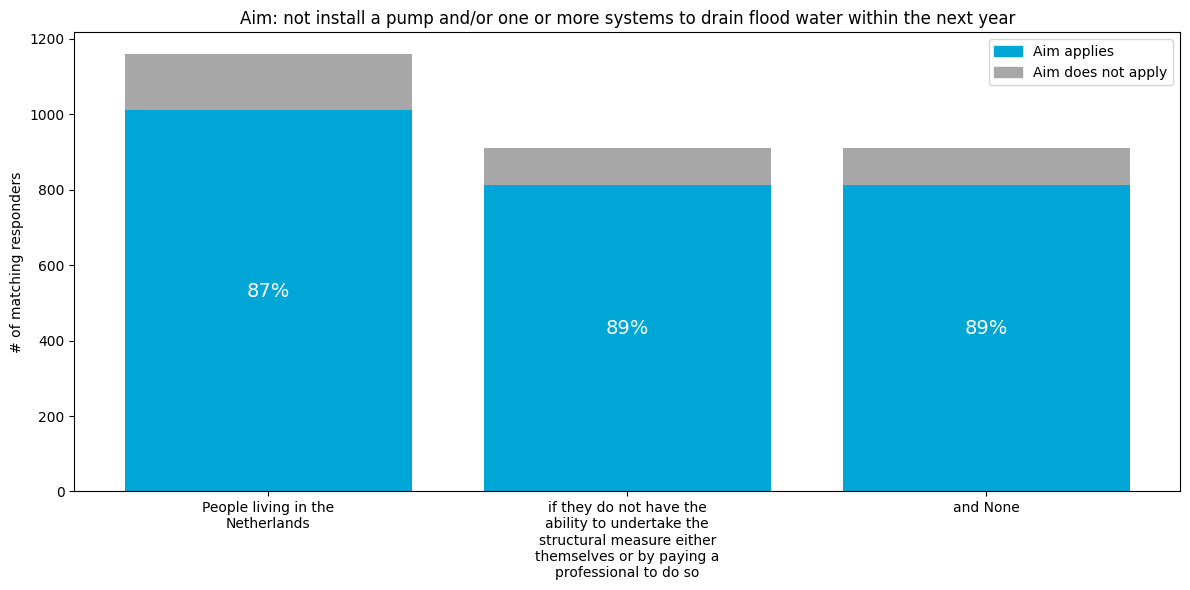

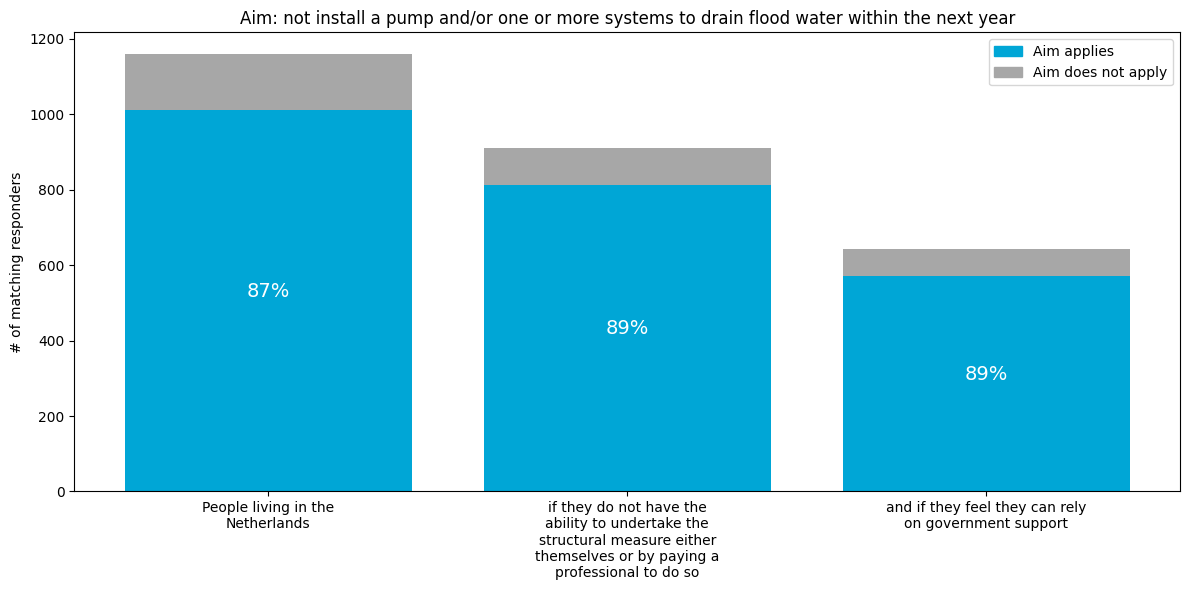

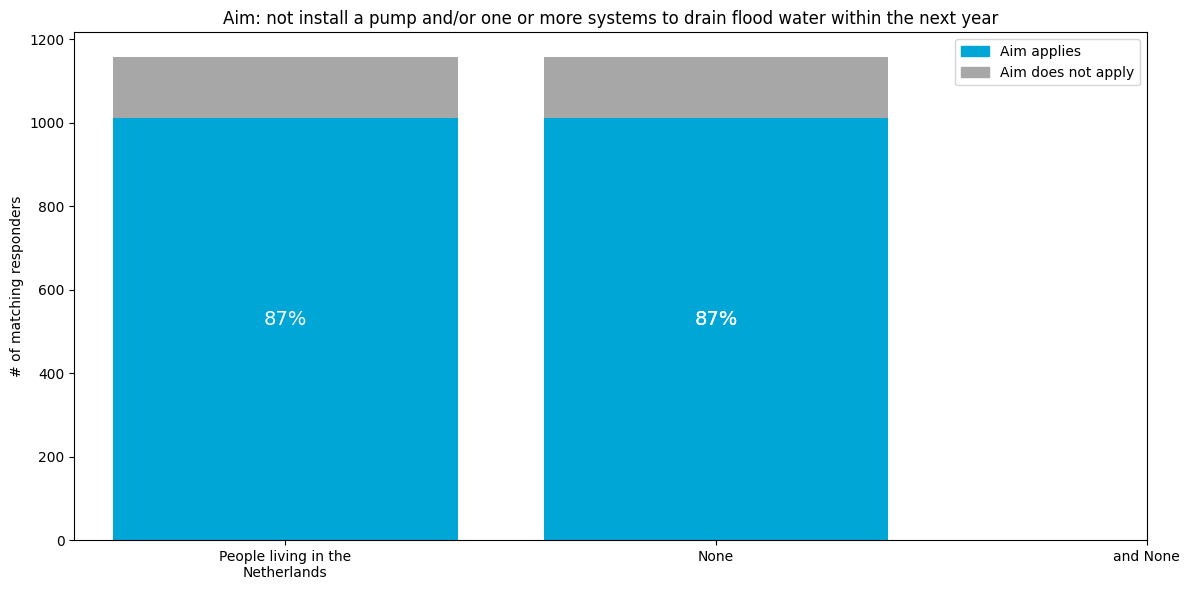

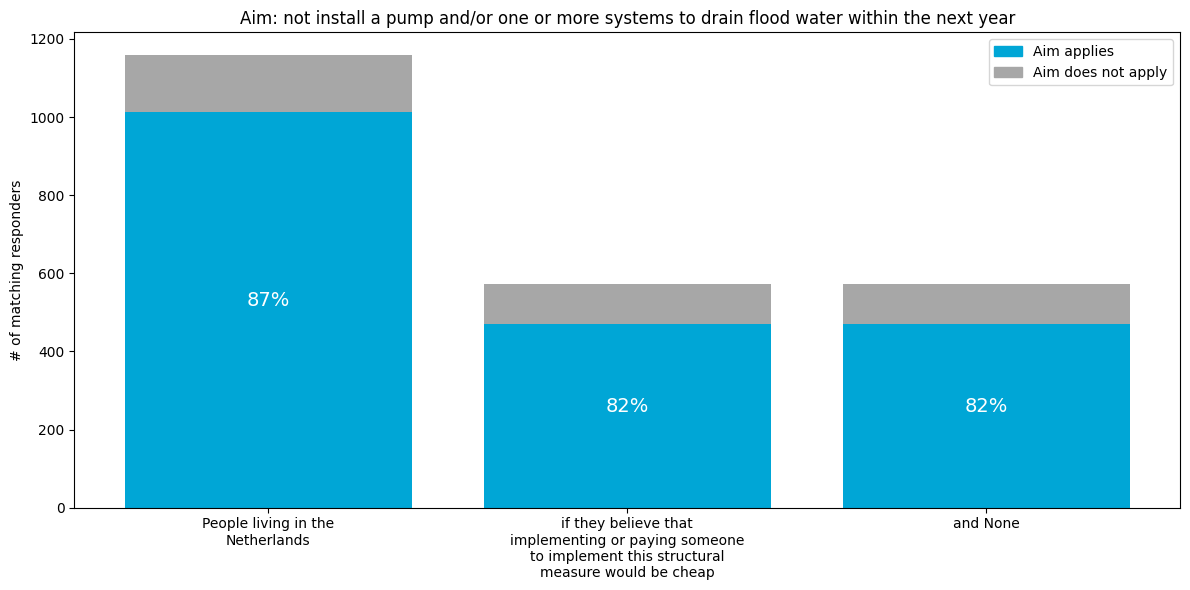

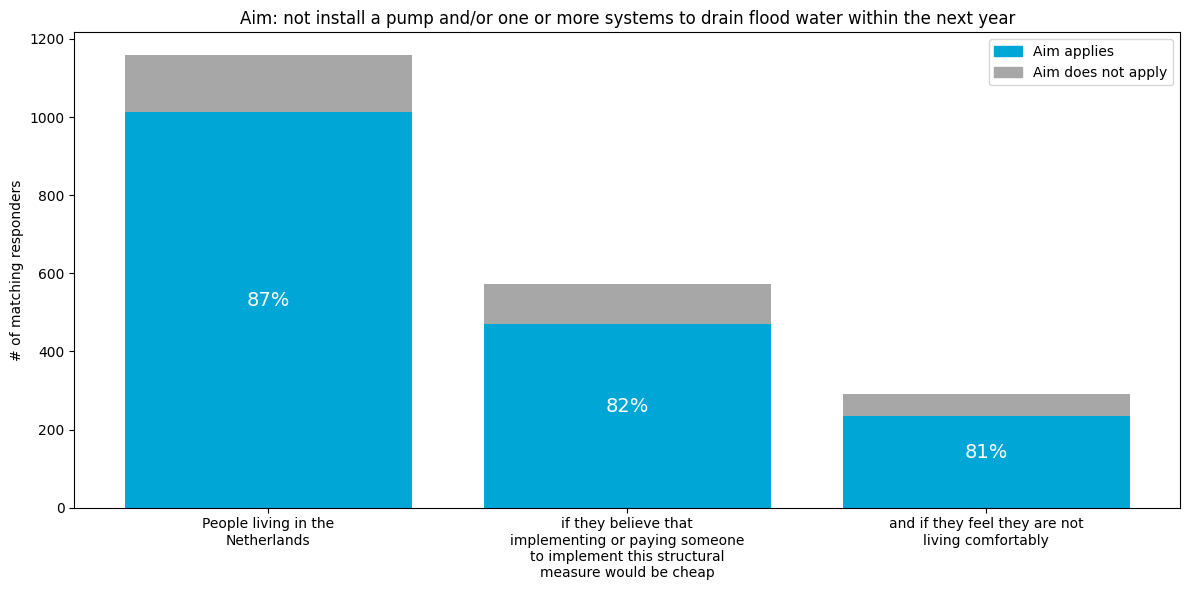

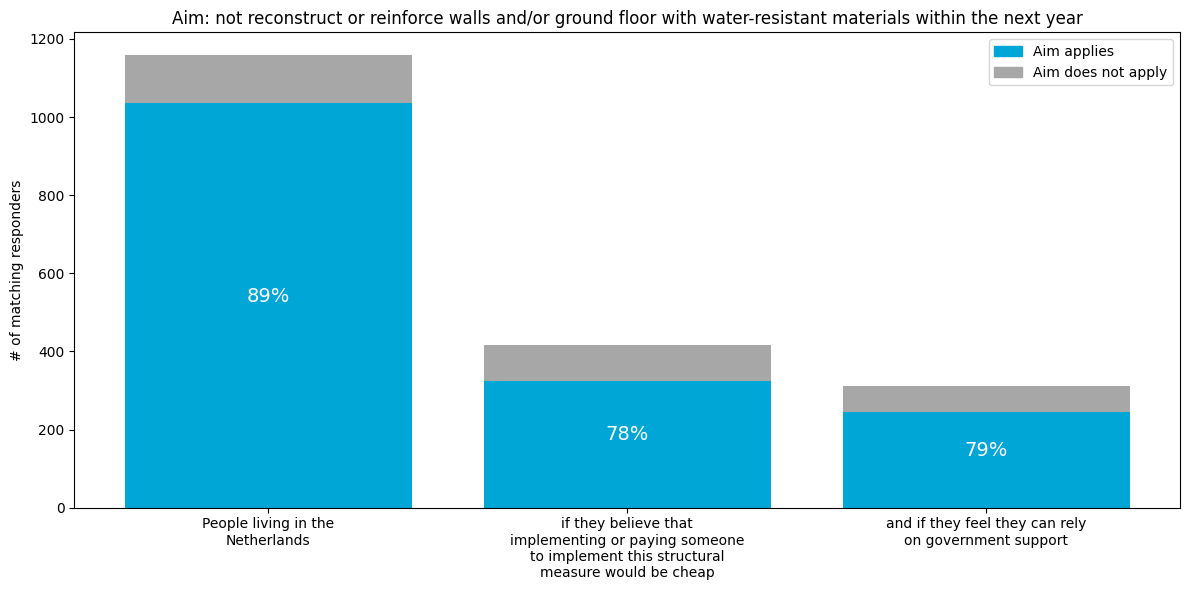

In [104]:
rows = len(statement_questions)

for i, row in statement_questions.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Adding legend
    blue_patch = mpatches.Patch(color='#00a6d6', label='Aim applies')
    grey_patch = mpatches.Patch(color='#a7a7a7', label='Aim does not apply')

    # Bar1: Total_count
    bar1 = ax.bar(str(row['Attribute']), row['Total_count'], color='#a7a7a7')
    ax.bar(str(row['Attribute']), row['Total_count'] * row['Aim_%_True'], color='#00a6d6')
    ax.text(str(row['Attribute']), row['Total_count'] * row['Aim_%_True']/2, f"{row['Aim_%_True']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Bar2: Condition1_count
    bar2 = ax.bar(str(row['Condition1']), row['Condition1_count'], color='#a7a7a7')
    ax.bar(str(row['Condition1']), row['Condition1_count'] * row['Condition1_Aim_%'], color='#00a6d6')
    ax.text(str(row['Condition1']), row['Condition1_count'] * row['Condition1_Aim_%']/2, f"{row['Condition1_Aim_%']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Bar3: Condition2_count
    bar3 = ax.bar(str(row['Condition2']), row['Condition2_count'], color='#a7a7a7')
    ax.bar(str(row['Condition2']), row['Condition2_count'] * row['Condition2_Aim_%'], color='#00a6d6')
    ax.text(str(row['Condition2']), row['Condition2_count'] * row['Condition2_Aim_%']/2, f"{row['Condition2_Aim_%']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Title of each plot
    ax.set_title("Aim: "+row['Aim_resp'])

    # Set ticks and labels
    ax.set_ylabel("# of matching responders")
    ax.set_xticks([0, 1, 2])
    wrapped_labels = [textwrap.fill(label, 30) for label in [row['Attribute'], row['Condition1_resp'], "and "+row['Condition2_resp']]]
    ax.set_xticklabels(wrapped_labels, rotation=0)

    ax.legend(handles=[blue_patch, grey_patch], loc='upper right')

    plt.tight_layout()
    plt.show()

Old stuff

In [265]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Create a parallel set graph for each aim
for i, row in statements_stats.iterrows():
    print(row)
    aimtrue = row['Aim']
    aimfalse = "not " + row['Aim']
    
    fig = go.Figure()

    # Adding paths
    fig.add_trace(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label = [row["Attribute"], "Do the Aim", "Don't do the Aim", 
                     str(row['Condition1']), "notcondition1",
                     "do the Aim "+row['Condition1'], "yescondition1butAimfalse", 
                     str(row['Condition2']), "notcondition2",
                     str(row['Condition2']) + " do the Aim", "yescondition2butAimfalse", 
                     ]
        ),
        link=dict(
            source=[0, 0, 1, 1, 3, 3, 5, 5, 7, 7],
            target=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            value=[row['Total_count'] * row['Aim_%_True'], row['Total_count'] * (1 - row['Aim_%_True']), 
                   row['Condition1_count'], row['Total_count'] * row['Aim_%_True'] - row['Condition1_count'],
                   row['Condition1_count'] * row['Condition1_Aim_%'], row['Condition1_count'] * (1 - row['Condition1_Aim_%']),
                   row['Condition2_count'], row['Condition1_count'] * row['Condition1_Aim_%'] - row['Condition2_count'],
                   row['Condition2_count'] * row['Condition2_Aim_%'], row['Condition2_count'] * (1 - row['Condition2_Aim_%'])]
        )
    ))

    fig.update_layout(title_text="Aim: " + row['Aim'], font_size=10)
    
    fig.show()


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM1
Total_count                                      976
Aim_%_True                                  0.768443
Condition1                         R1c_perc_cost_SM1
Condition1_count                                 632
Condition1_Aim_%                            0.890823
Condition2                                      None
Condition2_count                                 632
Condition2_Aim_%                            0.890823
Name: 0, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM1
Total_count                                      976
Aim_%_True                                  0.768443
Condition1                         R1c_perc_cost_SM1
Condition1_count                                 632
Condition1_Aim_%                            0.890823
Condition2                     R1a_self_efficacy_SM1
Condition2_count                                 572
Condition2_Aim_%                            0.926573
Name: 1, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM1
Total_count                                      976
Aim_%_True                                  0.768443
Condition1                                 R05_worry
Condition1_count                                 863
Condition1_Aim_%                            0.813441
Condition2                                      None
Condition2_count                                 863
Condition2_Aim_%                            0.813441
Name: 2, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM1
Total_count                                      976
Aim_%_True                                  0.768443
Condition1                                 R05_worry
Condition1_count                                 863
Condition1_Aim_%                            0.813441
Condition2                                    Q0_age
Condition2_count                                 381
Condition2_Aim_%                             0.91601
Name: 3, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM2
Total_count                                      976
Aim_%_True                                  0.772541
Condition1                                    Q0_age
Condition1_count                                 564
Condition1_Aim_%                            0.679078
Condition2                         R1c_perc_cost_SM2
Condition2_count                                 357
Condition2_Aim_%                            0.787115
Name: 4, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM2
Total_count                                      976
Aim_%_True                                  0.772541
Condition1                                    Q0_age
Condition1_count                                 412
Condition1_Aim_%                            0.900485
Condition2                                      None
Condition2_count                                 412
Condition2_Aim_%                            0.900485
Name: 5, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM2
Total_count                                      976
Aim_%_True                                  0.772541
Condition1                                    Q0_age
Condition1_count                                 412
Condition1_Aim_%                            0.900485
Condition2                     R1a_self_efficacy_SM2
Condition2_count                                 387
Condition2_Aim_%                            0.919897
Name: 6, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM2
Total_count                                      976
Aim_%_True                                  0.772541
Condition1                         R1c_perc_cost_SM2
Condition1_count                                 654
Condition1_Aim_%                            0.853211
Condition2                                      None
Condition2_count                                 654
Condition2_Aim_%                            0.853211
Name: 7, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM2
Total_count                                      976
Aim_%_True                                  0.772541
Condition1                         R1c_perc_cost_SM2
Condition1_count                                 654
Condition1_Aim_%                            0.853211
Condition2                     R1a_self_efficacy_SM2
Condition2_count                                 571
Condition2_Aim_%                            0.889667
Name: 8, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM3
Total_count                                      976
Aim_%_True                                  0.757172
Condition1                     R1a_self_efficacy_SM3
Condition1_count                                 822
Condition1_Aim_%                            0.818735
Condition2                                      None
Condition2_count                                 822
Condition2_Aim_%                            0.818735
Name: 9, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM3
Total_count                                      976
Aim_%_True                                  0.757172
Condition1                     R1a_self_efficacy_SM3
Condition1_count                                 822
Condition1_Aim_%                            0.818735
Condition2                         R1c_perc_cost_SM3
Condition2_count                                 537
Condition2_Aim_%                            0.919926
Name: 10, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_SM3
Total_count                                      976
Aim_%_True                                  0.757172
Condition1                         R1c_perc_cost_SM3
Condition1_count                                 633
Condition1_Aim_%                            0.849921
Condition2                                      None
Condition2_count                                 633
Condition2_Aim_%                            0.849921
Name: 11, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_NM2
Total_count                                      976
Aim_%_True                                   0.69877
Condition1                                 R05_worry
Condition1_count                                 863
Condition1_Aim_%                            0.732329
Condition2                                    Q0_age
Condition2_count                                 381
Condition2_Aim_%                            0.808399
Name: 12, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_NM3
Total_count                                      976
Aim_%_True                                    0.6875
Condition1                         R1c_perc_cost_NM3
Condition1_count                                 606
Condition1_Aim_%                            0.755776
Condition2                     R1a_self_efficacy_NM3
Condition2_count                                 425
Condition2_Aim_%                            0.818824
Name: 13, dtype: object


Attribute           People living in the Netherlands
Aim                            R2_implementation_NM6
Total_count                                      976
Aim_%_True                                  0.692623
Condition1                     R1a_self_efficacy_NM6
Condition1_count                                 743
Condition1_Aim_%                            0.740242
Condition2                         R1c_perc_cost_NM6
Condition2_count                                 413
Condition2_Aim_%                            0.808717
Name: 14, dtype: object


Previous, less relevant work:

In [266]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

responses_nadrop = aim_responses.dropna(axis=1)


for aim in chosen_aims:
    print(aim)
    X = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].values
    Y = responses_nadrop.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
    
    # Create and train logistic regression model
    clf_logreg = LogisticRegression(max_iter=1000)
    clf_logreg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf_logreg.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(("Accuracy is"), accuracy)

    # Get feature names
    feature_names = responses_nadrop.loc[:, ~responses_nadrop.columns.isin([aim])].columns

    # Get coefficients
    coefficients = clf_logreg.coef_[0]

    # Create a DataFrame to display feature names and corresponding coefficients
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

    # Sort DataFrame by absolute coefficient values to identify most impactful features
    coef_df["Absolute Coefficient"] = coef_df["Coefficient"].abs()
    coef_df_sorted = coef_df.sort_values(by="Absolute Coefficient", ascending=False)

    # Display the top features impacting the prediction
    print("Top features impacting the prediction:")
    print(coef_df_sorted.head())



NameError: name 'aim_responses' is not defined

In [ ]:
# Segment data by 'Q0_gender'
gender_groups = AllWave1.groupby('Q0_gender')

# Prepare a structure to hold the results of correlation analysis for each gender group
results = {}

# Iterate over each gender group and calculate correlations between selected conditions and aims
for gender, group in gender_groups:
    # Filter the group data for selected conditions and aims
    subgroup_data = group[selected_conditions + selected_aims].dropna()
    
    # Calculate the correlation matrix for the subgroup
    correlation_matrix = subgroup_data.corr()
    
    # Extract correlations between conditions and aims
    condition_aim_correlations = correlation_matrix.loc[selected_conditions, selected_aims]
    
    # Store the results
    results[gender] = condition_aim_correlations

# Due to the selection of a large number of conditions and aims, and for simplicity,
# let's display the results for the first gender group as an example
results[list(results.keys())[0]]


NameError: name 'selected_conditions' is not defined

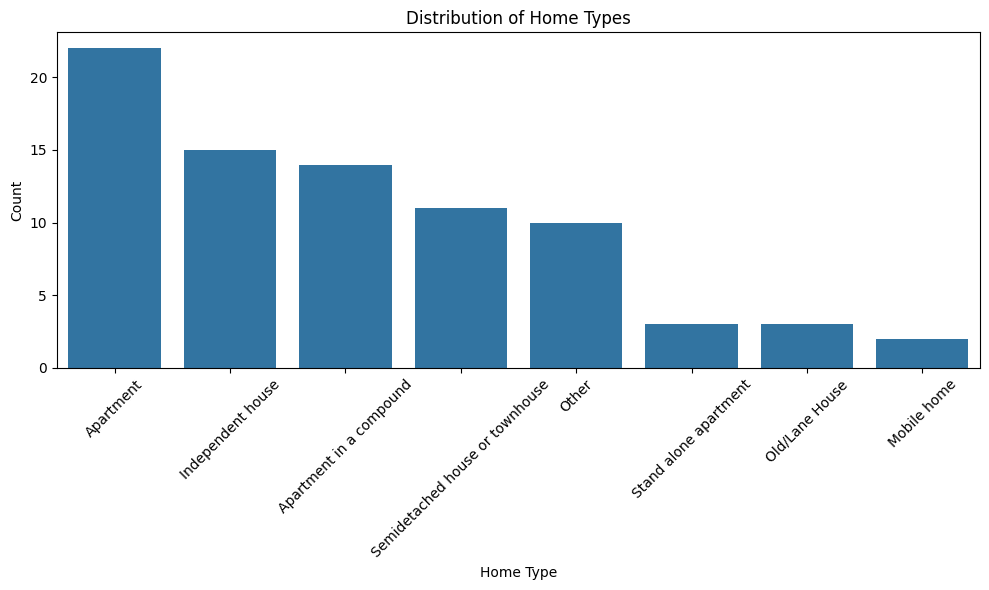

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping numerical values to home types
home_type_mapping_ID_NL_US = {
    1.: 'Apartment',
    2.: 'Semidetached house or townhouse',
    3.: 'Independent house',
    4.: 'Mobile home',
    97.: 'Other'
}
home_type_mapping_CN = {
    1.: 'Old/Lane House',
    2.: 'Stand alone apartment',
    3.: 'Apartment in a compound',
    4.: 'Villa',
    5.:	"Serviced Apartment",
    97.:	"Other",
    98.:	"Don't know"
}

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_ID_NL_US' with the provided mapping
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].map(home_type_mapping_ID_NL_US)

# Before applying the mapping for 'Q1_home_CN', ensure it's in the correct numeric format and handle NaN as necessary
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].apply(pd.to_numeric, errors='coerce')

# Apply mapping for 'Q1_home_CN' with the provided mapping
AllWave1['Q1_home_CN'] = AllWave1['Q1_home_CN'].map(home_type_mapping_CN)

# Fill NaN values in 'Q1_home_ID_NL_US' with the values from 'Q1_home_CN_mapped'
AllWave1['Q1_home_ID_NL_US'] = AllWave1['Q1_home_ID_NL_US'].fillna(AllWave1['Q1_home_CN'])


# Visualise the distribution of home types
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', order=AllWave1['Q1_home_ID_NL_US'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

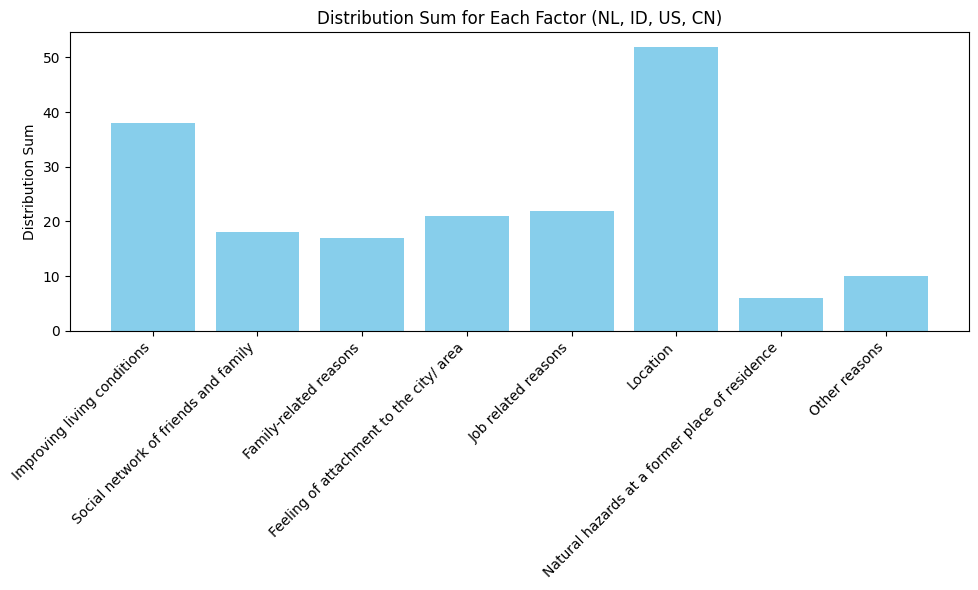

In [ ]:
# Calculate distribution sum for each factor
distribution_sums = []
factors = []

# Define mapping of response options to factors
factor_mapping = {
    'Improving living conditions': 'Q11_search_improve',
    'Social network of friends and family': 'Q11_search_social',
    'Family-related reasons': 'Q11_search_family',
    'Feeling of attachment to the city/ area': 'Q11_search_area',
    'Job related reasons': 'Q11_search_job',
    'Location': 'Q11_search_location',
    'Natural hazards at a former place of residence': 'Q11_search_hazard',
    'Other reasons': 'Q11_search_other',
}

for factor, column in factor_mapping.items():
    distribution_sum = AllWave1[column].sum()
    factors.append(factor)
    distribution_sums.append(distribution_sum)

# Create distribution plot
plt.figure(figsize=(10, 6))
plt.bar(factors, distribution_sums, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Distribution Sum')
plt.title('Distribution Sum for Each Factor (NL, ID, US, CN)')
plt.tight_layout()
plt.show()

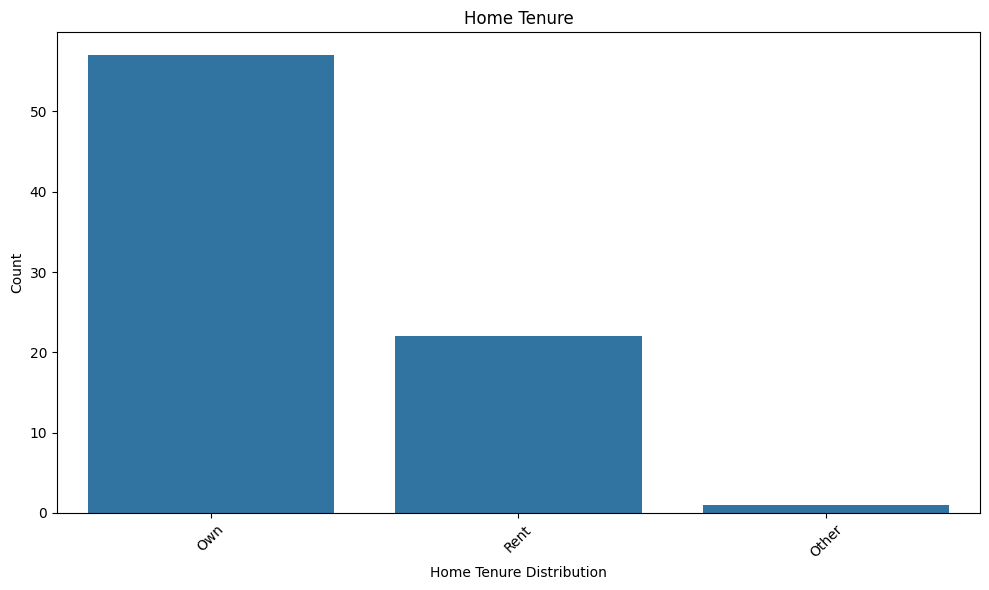

In [ ]:
# Mapping for home tenure
rent_own_mapping = {
    1: 'Rent',
    2: "Own",
    97: 'Other',
}

# Apply mapping
AllWave1['rent_own_mapping'] = AllWave1['Q5_home_tenure'].map(rent_own_mapping)

# Visualize the distribution of home tenure
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='rent_own_mapping', order=AllWave1['rent_own_mapping'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Home Tenure')
plt.xlabel('Home Tenure Distribution')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

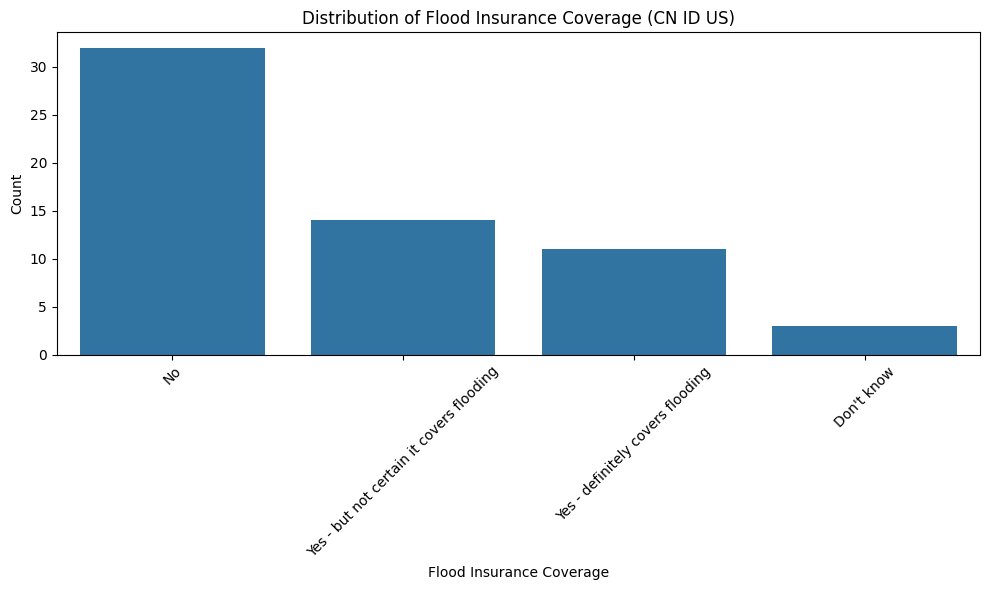

In [ ]:
# Mapping for flood insurance coverage
insurance_coverage_mapping = {
    1: 'Yes - definitely covers flooding',
    2: "Yes - but not certain it covers flooding",
    3: 'No',
    98: "Don't know"
}

# Apply mapping
AllWave1['insurance_coverage_mapped'] = AllWave1['Q41_ins_CN_ID_US'].map(insurance_coverage_mapping)

# Visualize the distribution of insurance coverage
plt.figure(figsize=(10, 6))
sns.countplot(data=AllWave1, x='insurance_coverage_mapped', order=AllWave1['insurance_coverage_mapped'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Flood Insurance Coverage (CN ID US)')
plt.xlabel('Flood Insurance Coverage')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

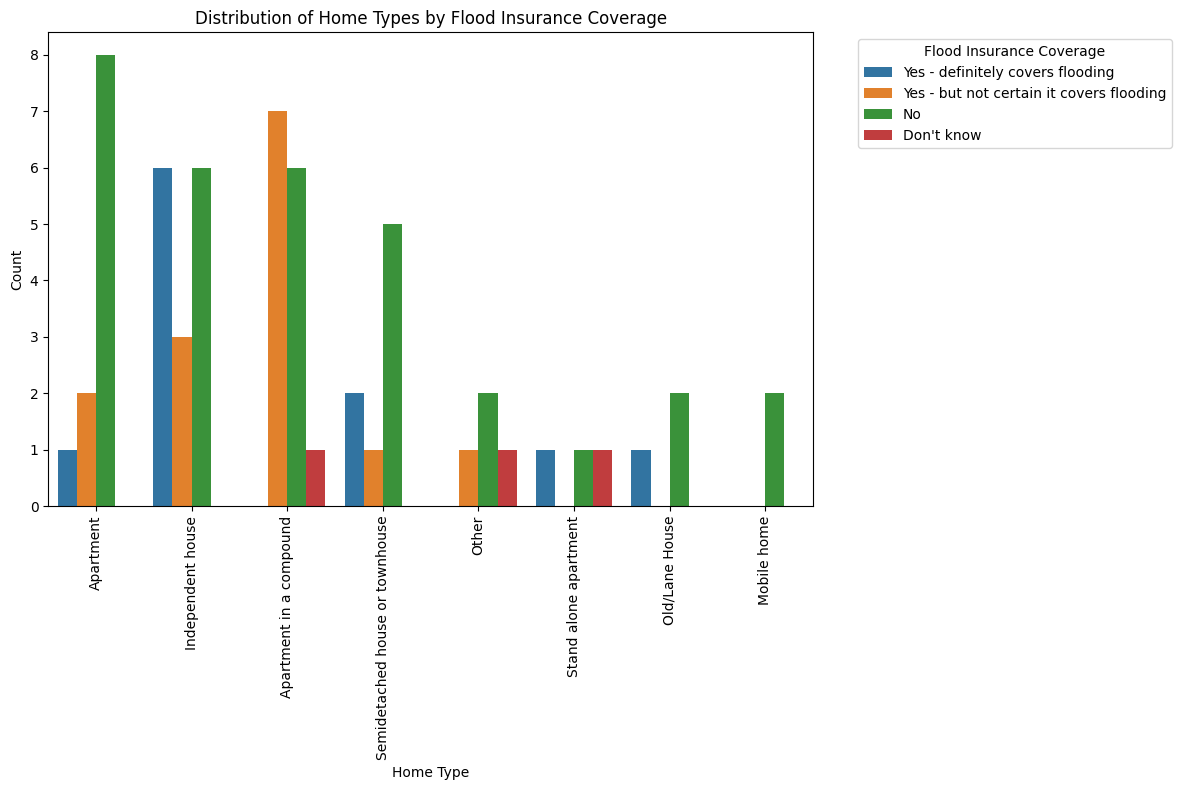

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='Q1_home_ID_NL_US', hue='insurance_coverage_mapped', 
              order=AllWave1['Q1_home_ID_NL_US'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Types by Flood Insurance Coverage')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


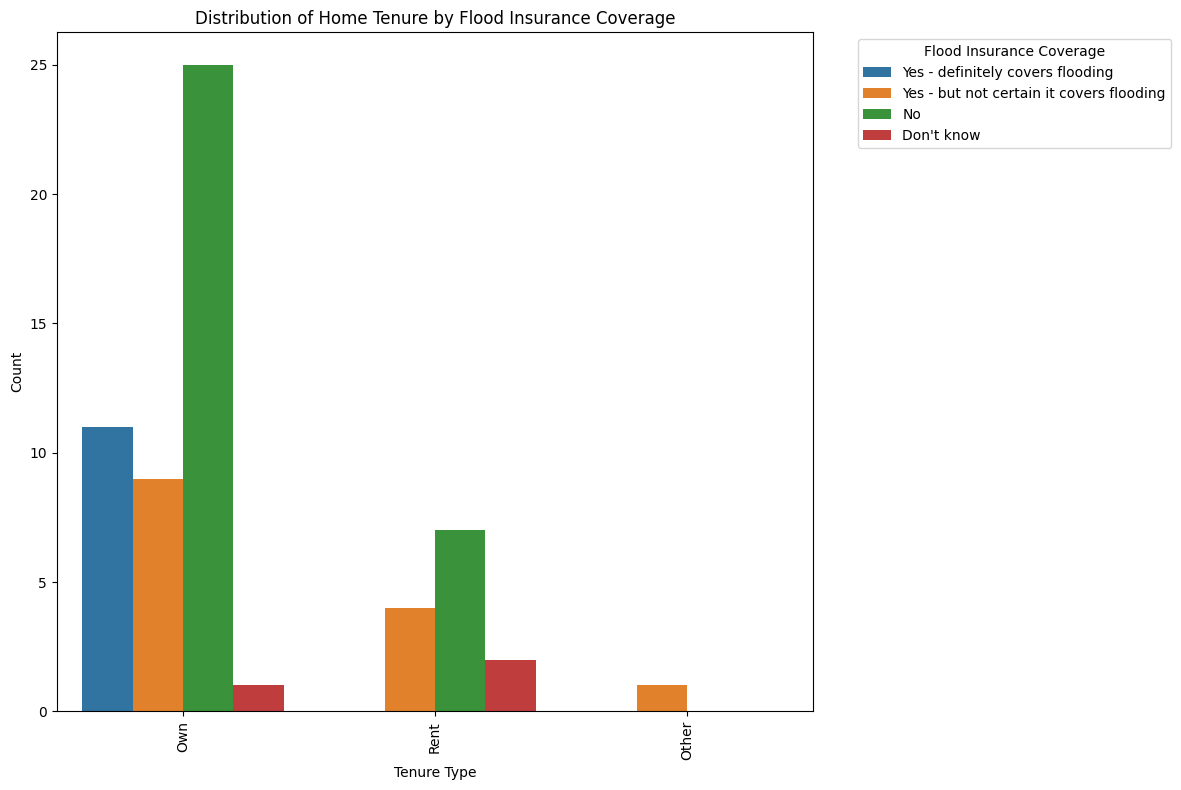

In [ ]:
# Assuming 'AllWave1' DataFrame already has the 'Q1_home_ID_NL_US' and 'Q41_ins_CN_ID_US' columns mapped to their textual descriptions

# Ensure the 'Q1_home_ID_NL_US' column is filled with 'Q1_home_CN' values for NaNs as you've done before
# Note: This step should already be done as per your previous message

# Visualize the distribution of home types with insurance coverage segmentation
plt.figure(figsize=(12, 8))
sns.countplot(data=AllWave1, x='rent_own_mapping', hue='insurance_coverage_mapped', order=AllWave1['rent_own_mapping'].value_counts().index,
              hue_order=['Yes - definitely covers flooding', 'Yes - but not certain it covers flooding', 'No', "Don't know"])
plt.xticks(rotation=90)
plt.title('Distribution of Home Tenure by Flood Insurance Coverage')
plt.xlabel('Tenure Type')
plt.ylabel('Count')
plt.legend(title='Flood Insurance Coverage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
correlation_data = AllWave1[["Q18_flood_exp", "R05_worry", "R2_implementation_NM4"]].copy()
# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix

,Q18_flood_exp,R05_worry,R2_implementation_NM4
Q18_flood_exp,1.000000,0.261944,-0.129233
R05_worry,0.261944,1.000000,-0.282069
R2_implementation_NM4,-0.129233,-0.282069,1.000000


In [ ]:
correlation_data = pd.DataFrame()
correlation_data['Q44_social_expectation'] = AllWave1['Q44_social_expectation'].copy()

# Create a new column that counts the occurrences of value == 1 in the specified columns
correlation_data['sum of household infrastructure change'] = AllWave1[['R2_implementation_SM1',
                                          'R2_implementation_SM2',
                                          'R2_implementation_SM3',
                                          'R2_implementation_SM4',
                                          'R2_implementation_SM5',
                                          'R2_implementation_SM6',
                                          'R2_implementation_SM7']].apply(lambda x: x.sum(), axis=1)

# Adjust 'Q41_ins_CN_ID_US' column based on the given condition
correlation_data['Intentional Flood insurance'] = AllWave1['Q41_ins_CN_ID_US'].apply(lambda x: 0 if x != 1 else x)

# Calculate Spearman correlation
correlation_matrix = correlation_data.corr(method='spearman')

correlation_matrix


,Q44_social_expectation,sum of household infrastructure change,Intentional Flood insurance
Q44_social_expectation,1.000000,-0.397670,0.338019
sum of household infrastructure change,-0.397670,1.000000,-0.263891
Intentional Flood insurance,0.338019,-0.263891,1.000000
